# **Housing Price Prediction**
#### **using Regression Models boosted with a NVIDIA GPU P100**

<div align="center">
 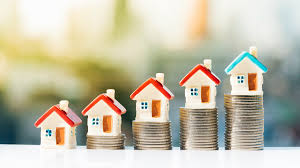
</div>

#### I am happy I was able to utilize a GPU while training my xgb, lgbm, and catboost models. This resulted in quicker training and better hyperparameters training. 

#### The regression models ridge, catboost, xgboost, and lgbm work well. Results improve when ensembled. Feature Engineering, identifying and removing outliers, and hyperparameter tuning can drastically improve accuracy. 

#### Keras Neutral Nets work but results were not as accurate. 

#### GPU P100 works better than T4X2. GPU saves alot of time when tuning regression model hyperparameters. 

#### I referenced these two very helpful notebooks while builting this. My feature engineering follows the work flow found here, [feature engineering](https://www.kaggle.com/code/angqx95/data-science-workflow-top-2-with-tuning#3.-Feature-Engineering) The mapping of useful and useless features for the regression models can be found in the following notebook. This notebook also uses the stacked regression model from Ski-kit which works better than assigning weights to each regression model for predictions. [stacking](https://www.kaggle.com/code/aliffaagnur/house-predict-eda-feature-engineering-stacking/notebook)

#### At time of publishing, I scored 49/6,648 in the top 1%!
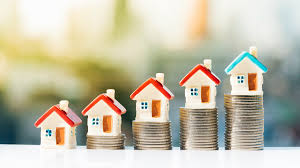

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
pd.set_option('display.max_columns', None) 
warnings.simplefilter(action='ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


#### Upload competition data into dataframes

In [2]:
train = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col=0)
test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col=0)

print("train data shape: ", train.shape)
print("test data shape: ", test.shape)
print('\n')

train.head()

train data shape:  (1460, 80)
test data shape:  (1459, 79)




MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd        NaN   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1  

## **Exploratory Data Analysis**

#### Check for columns with large numbers of null values in the training and test set

In [3]:
train_null = train.isna().sum()
test_null  = test.isna().sum()
train_null.drop(labels='SalePrice', axis=0, inplace=True)
#Compare training to test set null counts
train_null.compare(test_null).sort_values(by='self', ascending=False,).head(20)

self   other
PoolQC        1453.0  1456.0
MiscFeature   1406.0  1408.0
Alley         1369.0  1352.0
Fence         1179.0  1169.0
MasVnrType     872.0   894.0
FireplaceQu    690.0   730.0
LotFrontage    259.0   227.0
GarageType      81.0    76.0
GarageYrBlt     81.0    78.0
GarageFinish    81.0    78.0
GarageQual      81.0    78.0
GarageCond      81.0    78.0
BsmtFinType2    38.0    42.0
BsmtExposure    38.0    44.0
BsmtFinType1    37.0    42.0
BsmtCond        37.0    45.0
BsmtQual        37.0    44.0
MasVnrArea       8.0    15.0
Electrical       1.0     0.0
GarageArea       0.0     1.0

In [4]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0) #training, validation, and test set
y = train[['SalePrice']] #target for prediction

<Axes: title={'center': 'Number of missing rows'}, xlabel='features', ylabel='sum'>

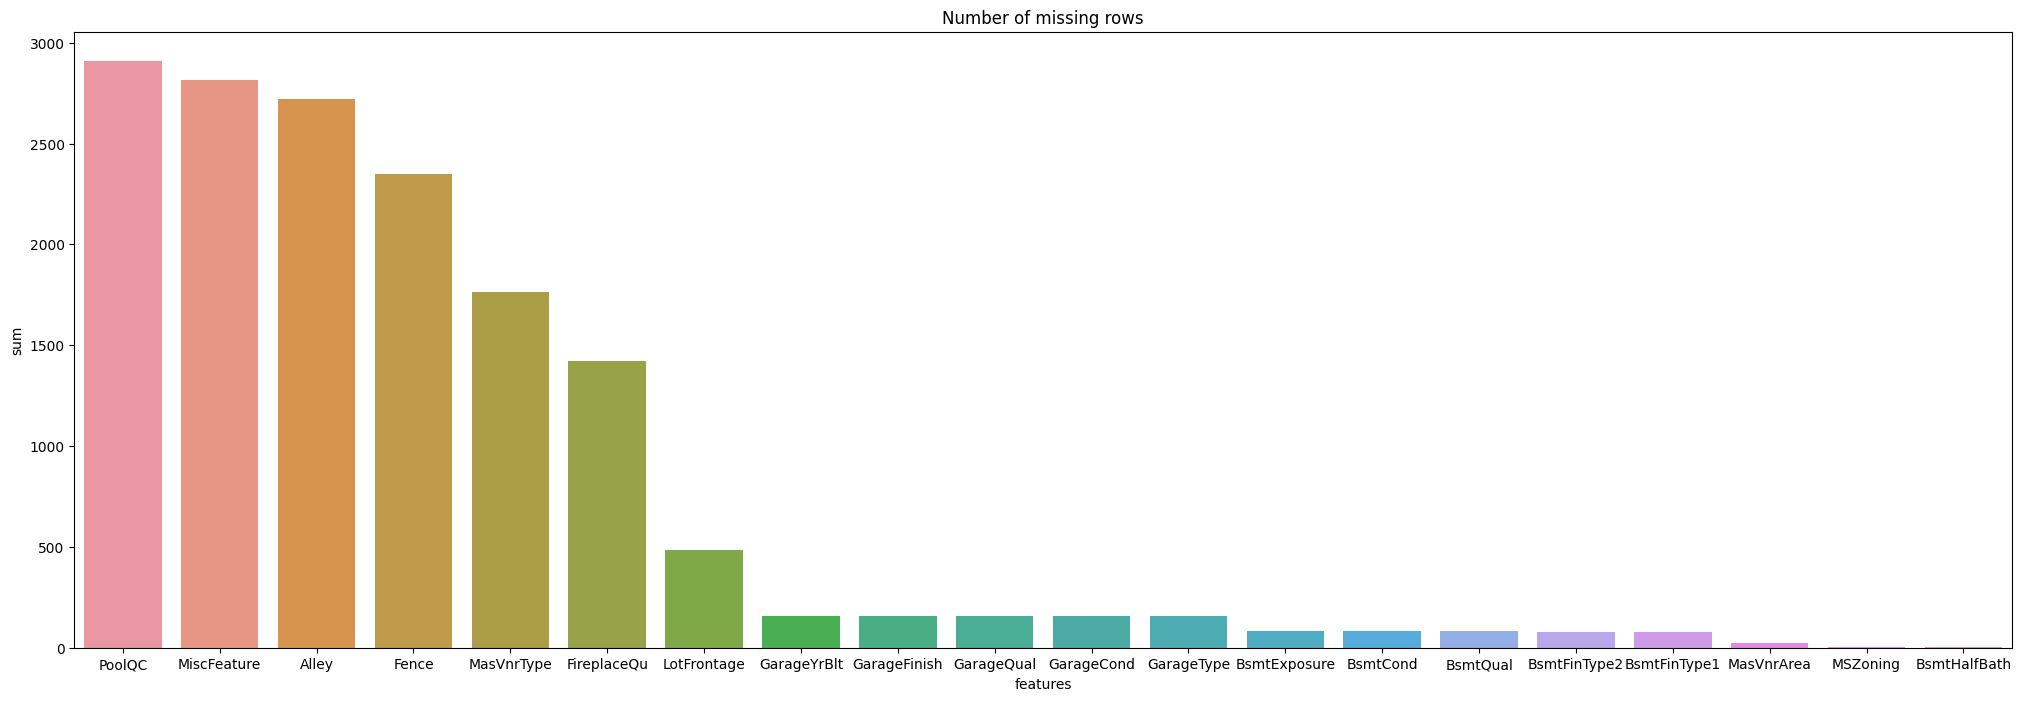

In [5]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

#### Drop mostly null columns from dataset. 

In [6]:
X.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1, inplace=True)

#### Split the features into their own groupings for preprocessing

In [7]:
categorical_feature = X.select_dtypes(include='object').columns.tolist()

numerical_feature   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_feature   = [col for col in numerical_feature if col != 'Id']

discrete_feature    = [col for col in numerical_feature if len(X[col].unique()) < 50]
continuous_feature  = [col for col in numerical_feature if col not in discrete_feature]

print(f'Number of Categorical Feature : {len(categorical_feature)}')
print(f'Number of Numerical Feature   : {len(numerical_feature)}')
print(f'Number of Discrete Feature    : {len(discrete_feature)}')
print(f'Number of Continous Feature   : {len(continuous_feature)}')

Number of Categorical Feature : 39
Number of Numerical Feature   : 36
Number of Discrete Feature    : 18
Number of Continous Feature   : 18


#### Compare distributions of the continuous features in the training and test sets

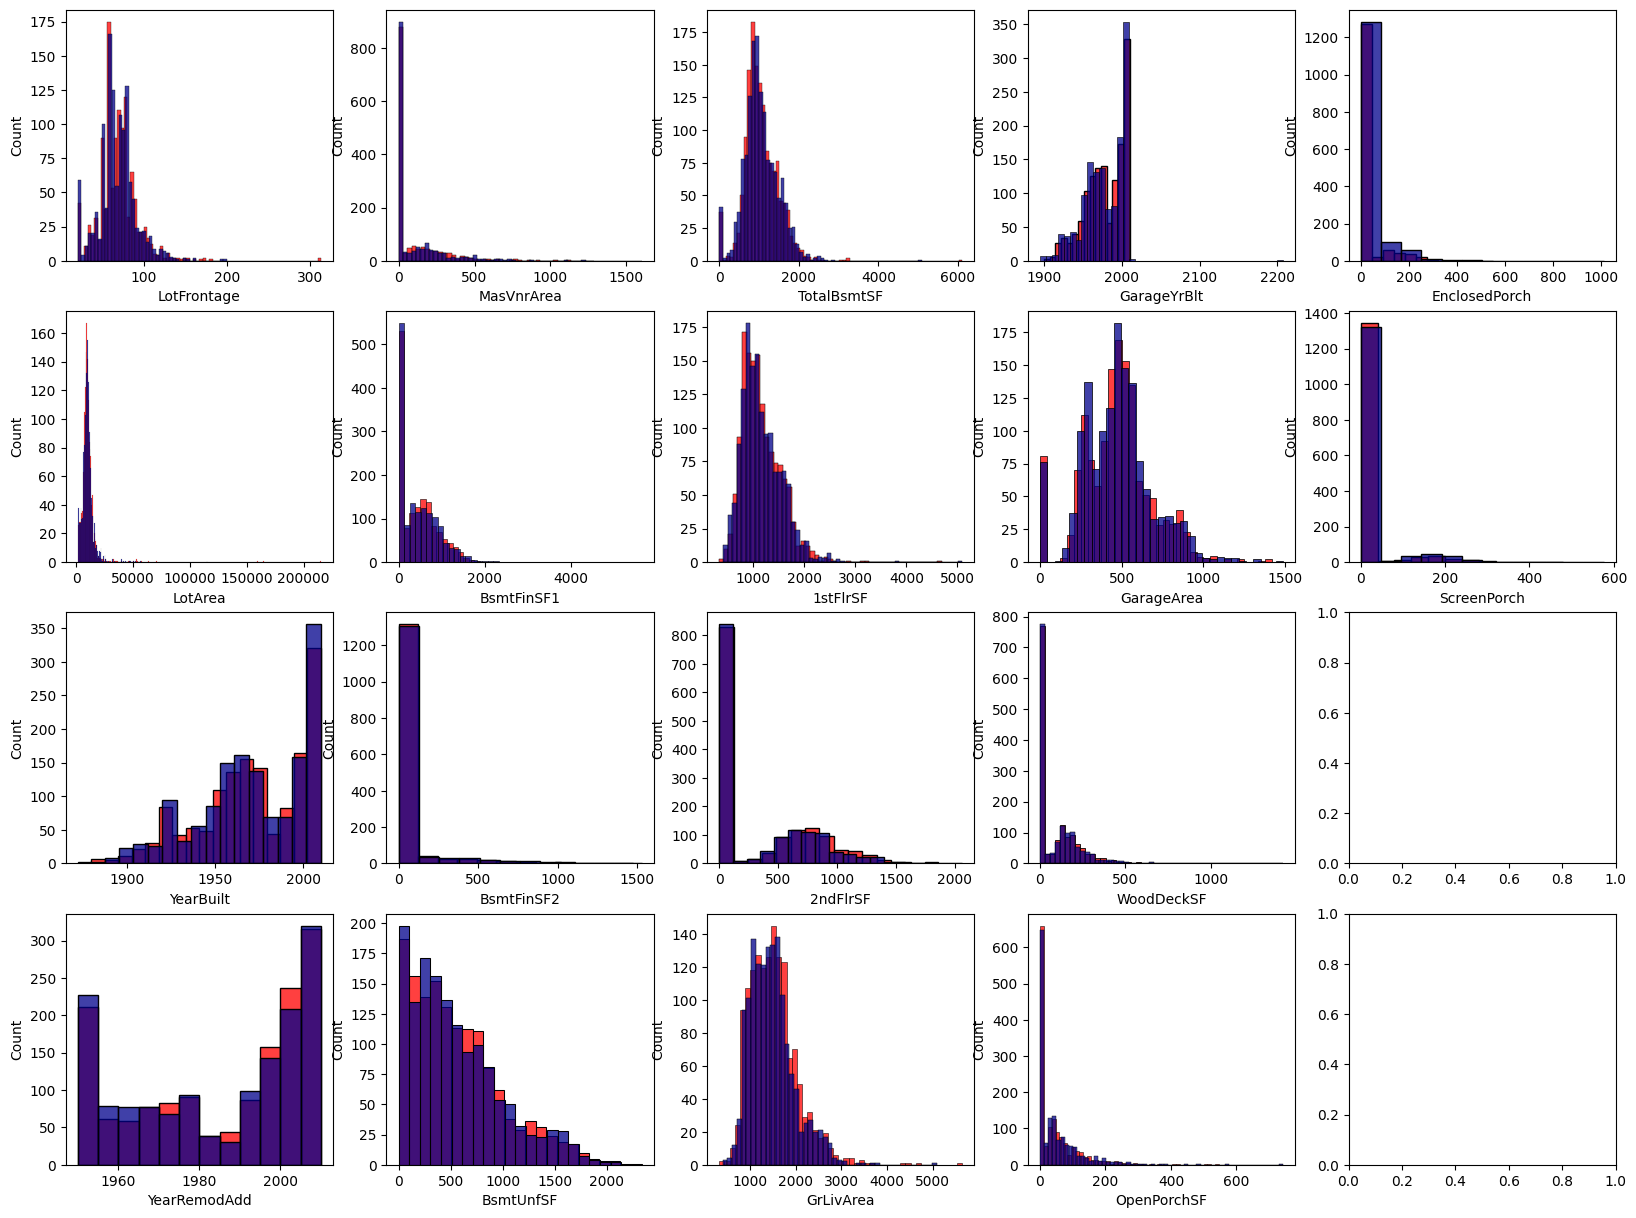

In [8]:
fig , axes = plt.subplots(nrows=4, ncols=5, figsize=(20,15))

for i, feature in enumerate(continuous_feature):
    sns.histplot(data= train, x=feature, ax=axes[i%4,i//4], color='red')
    sns.histplot(data= test,  x=feature, ax=axes[i%4,i//4],  color='darkblue')
plt.show()

#### Plot the numerical features to discover insights of the distributions

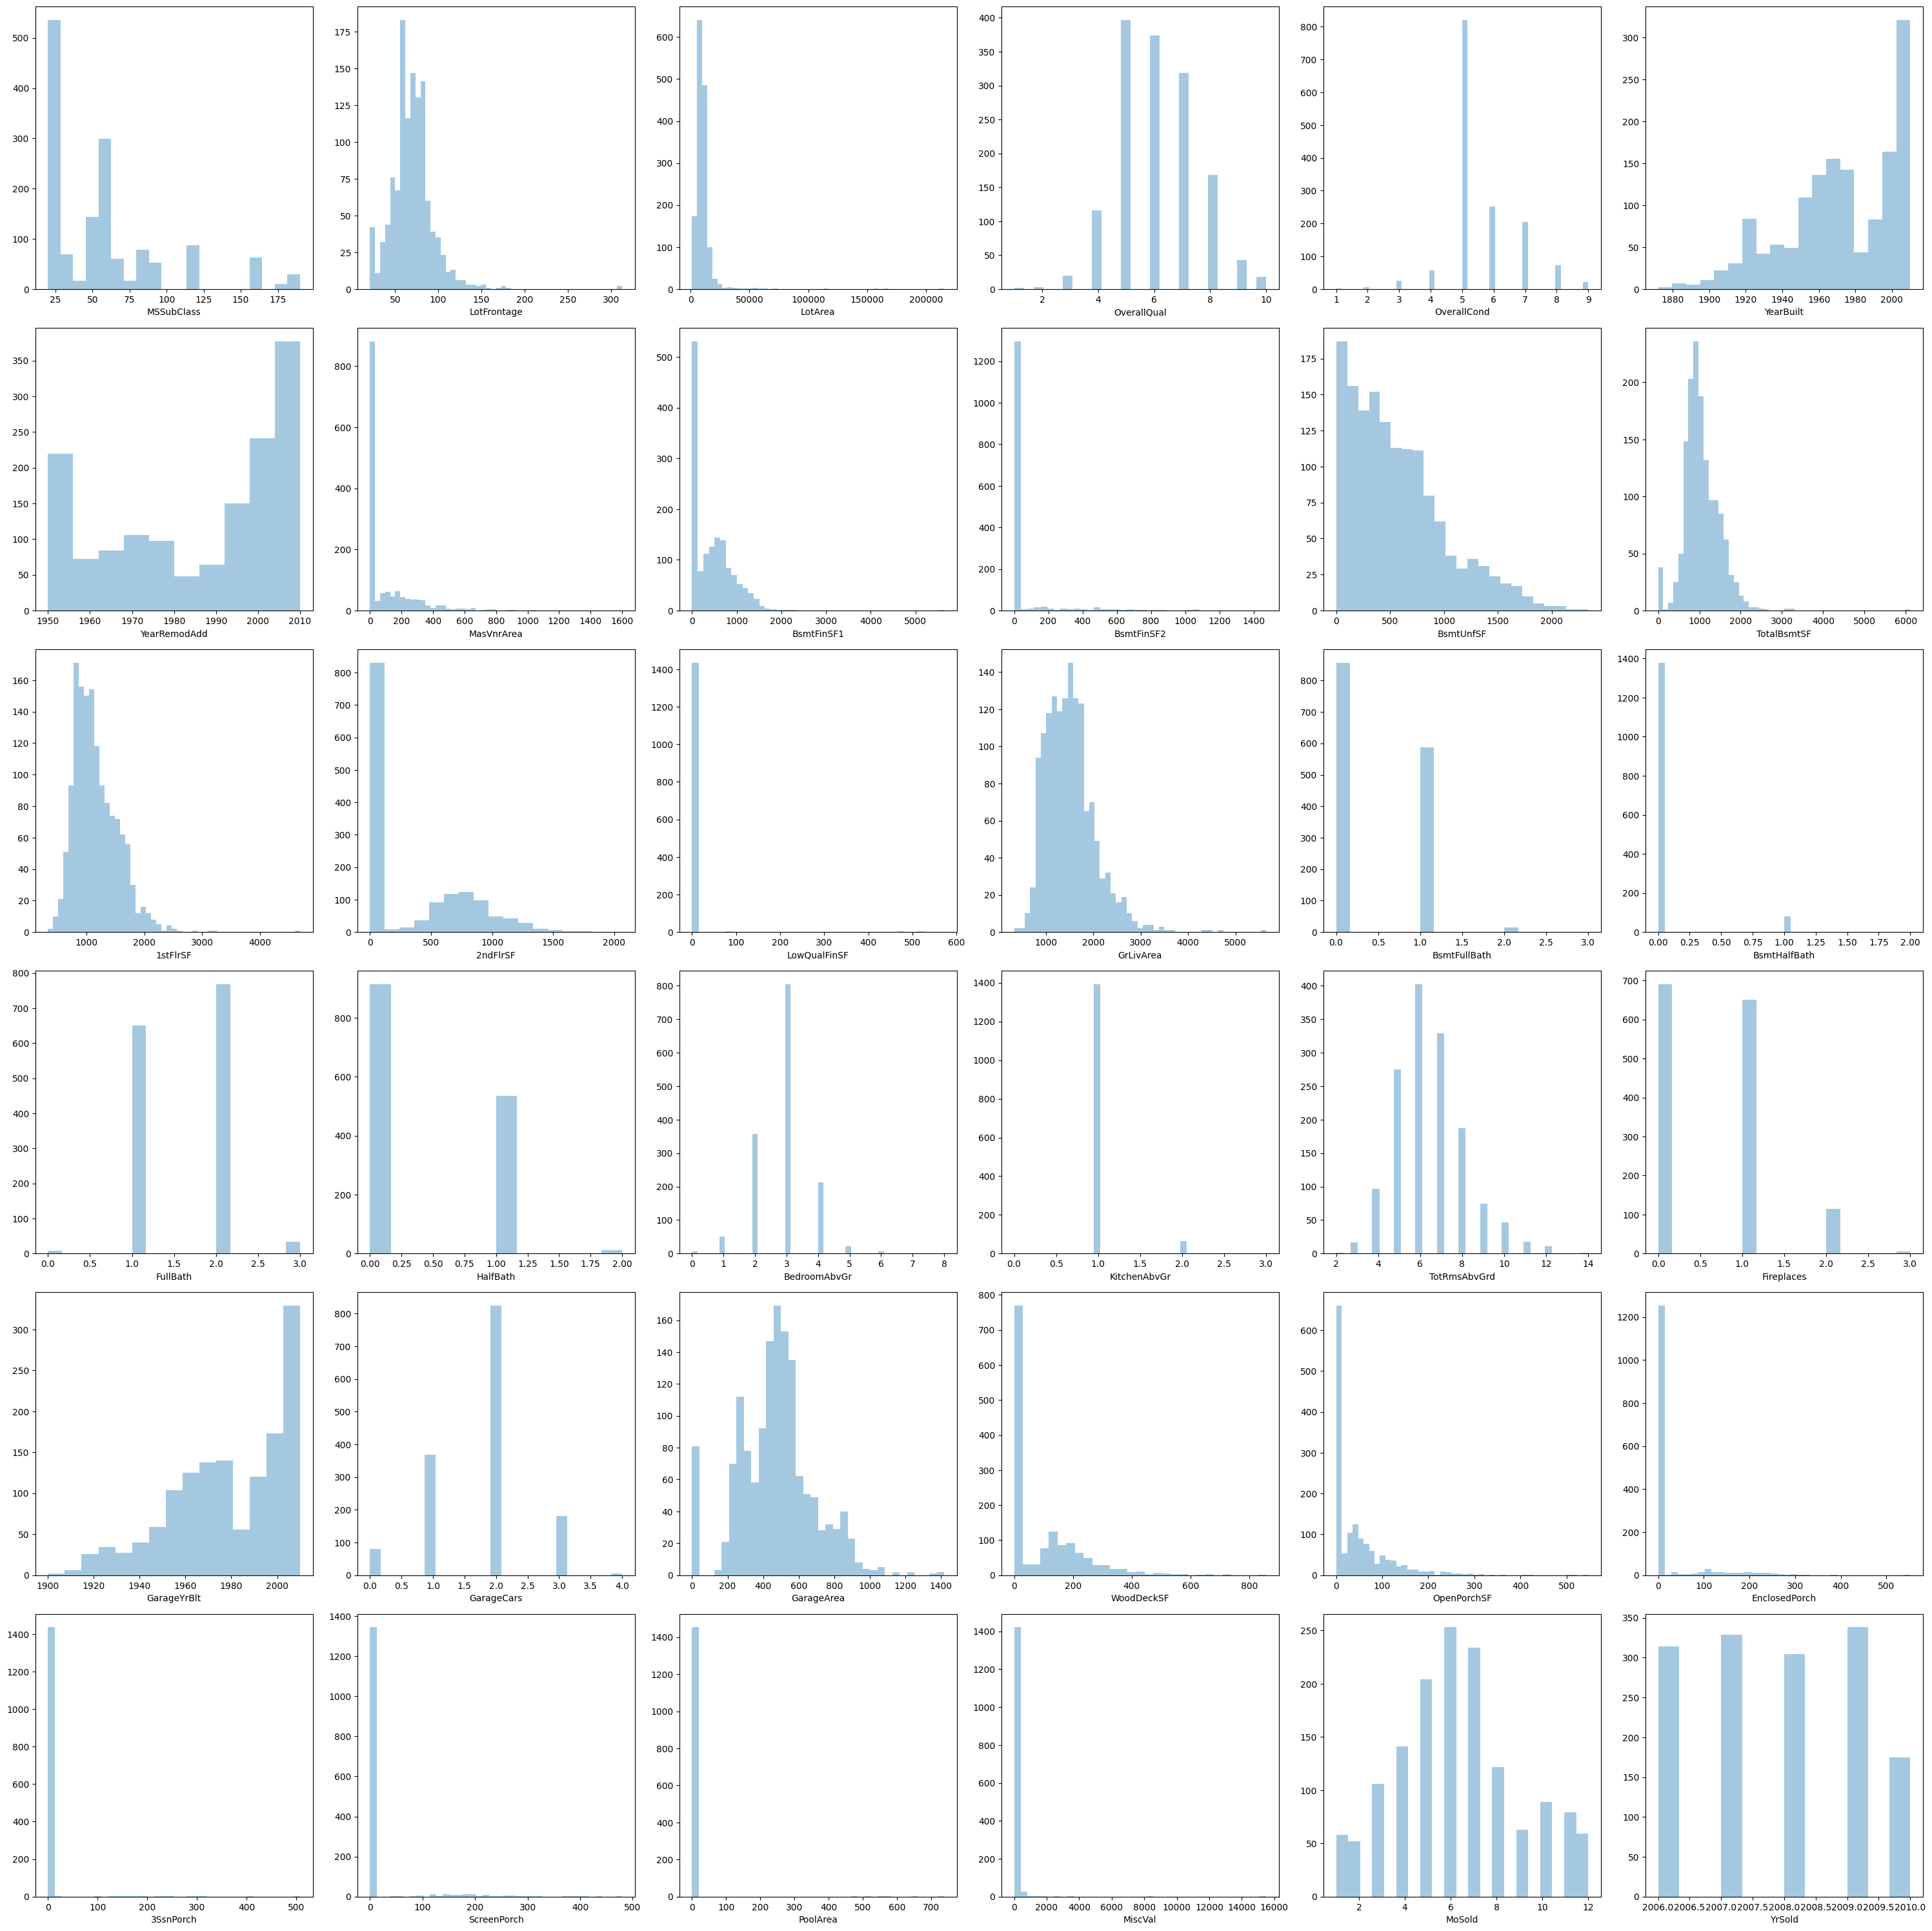

In [9]:
fig = plt.figure(figsize=(30,30))
for index,col in enumerate(train[numerical_feature]):
    plt.subplot(6,6,index+1)
    sns.distplot(train[numerical_feature].loc[:,col].dropna(), kde=False)
    if index+1 > len(numerical_feature):
        pass
fig.tight_layout(pad=1.0)

#### Plotting discrete columns, columns with less than 50 unique values

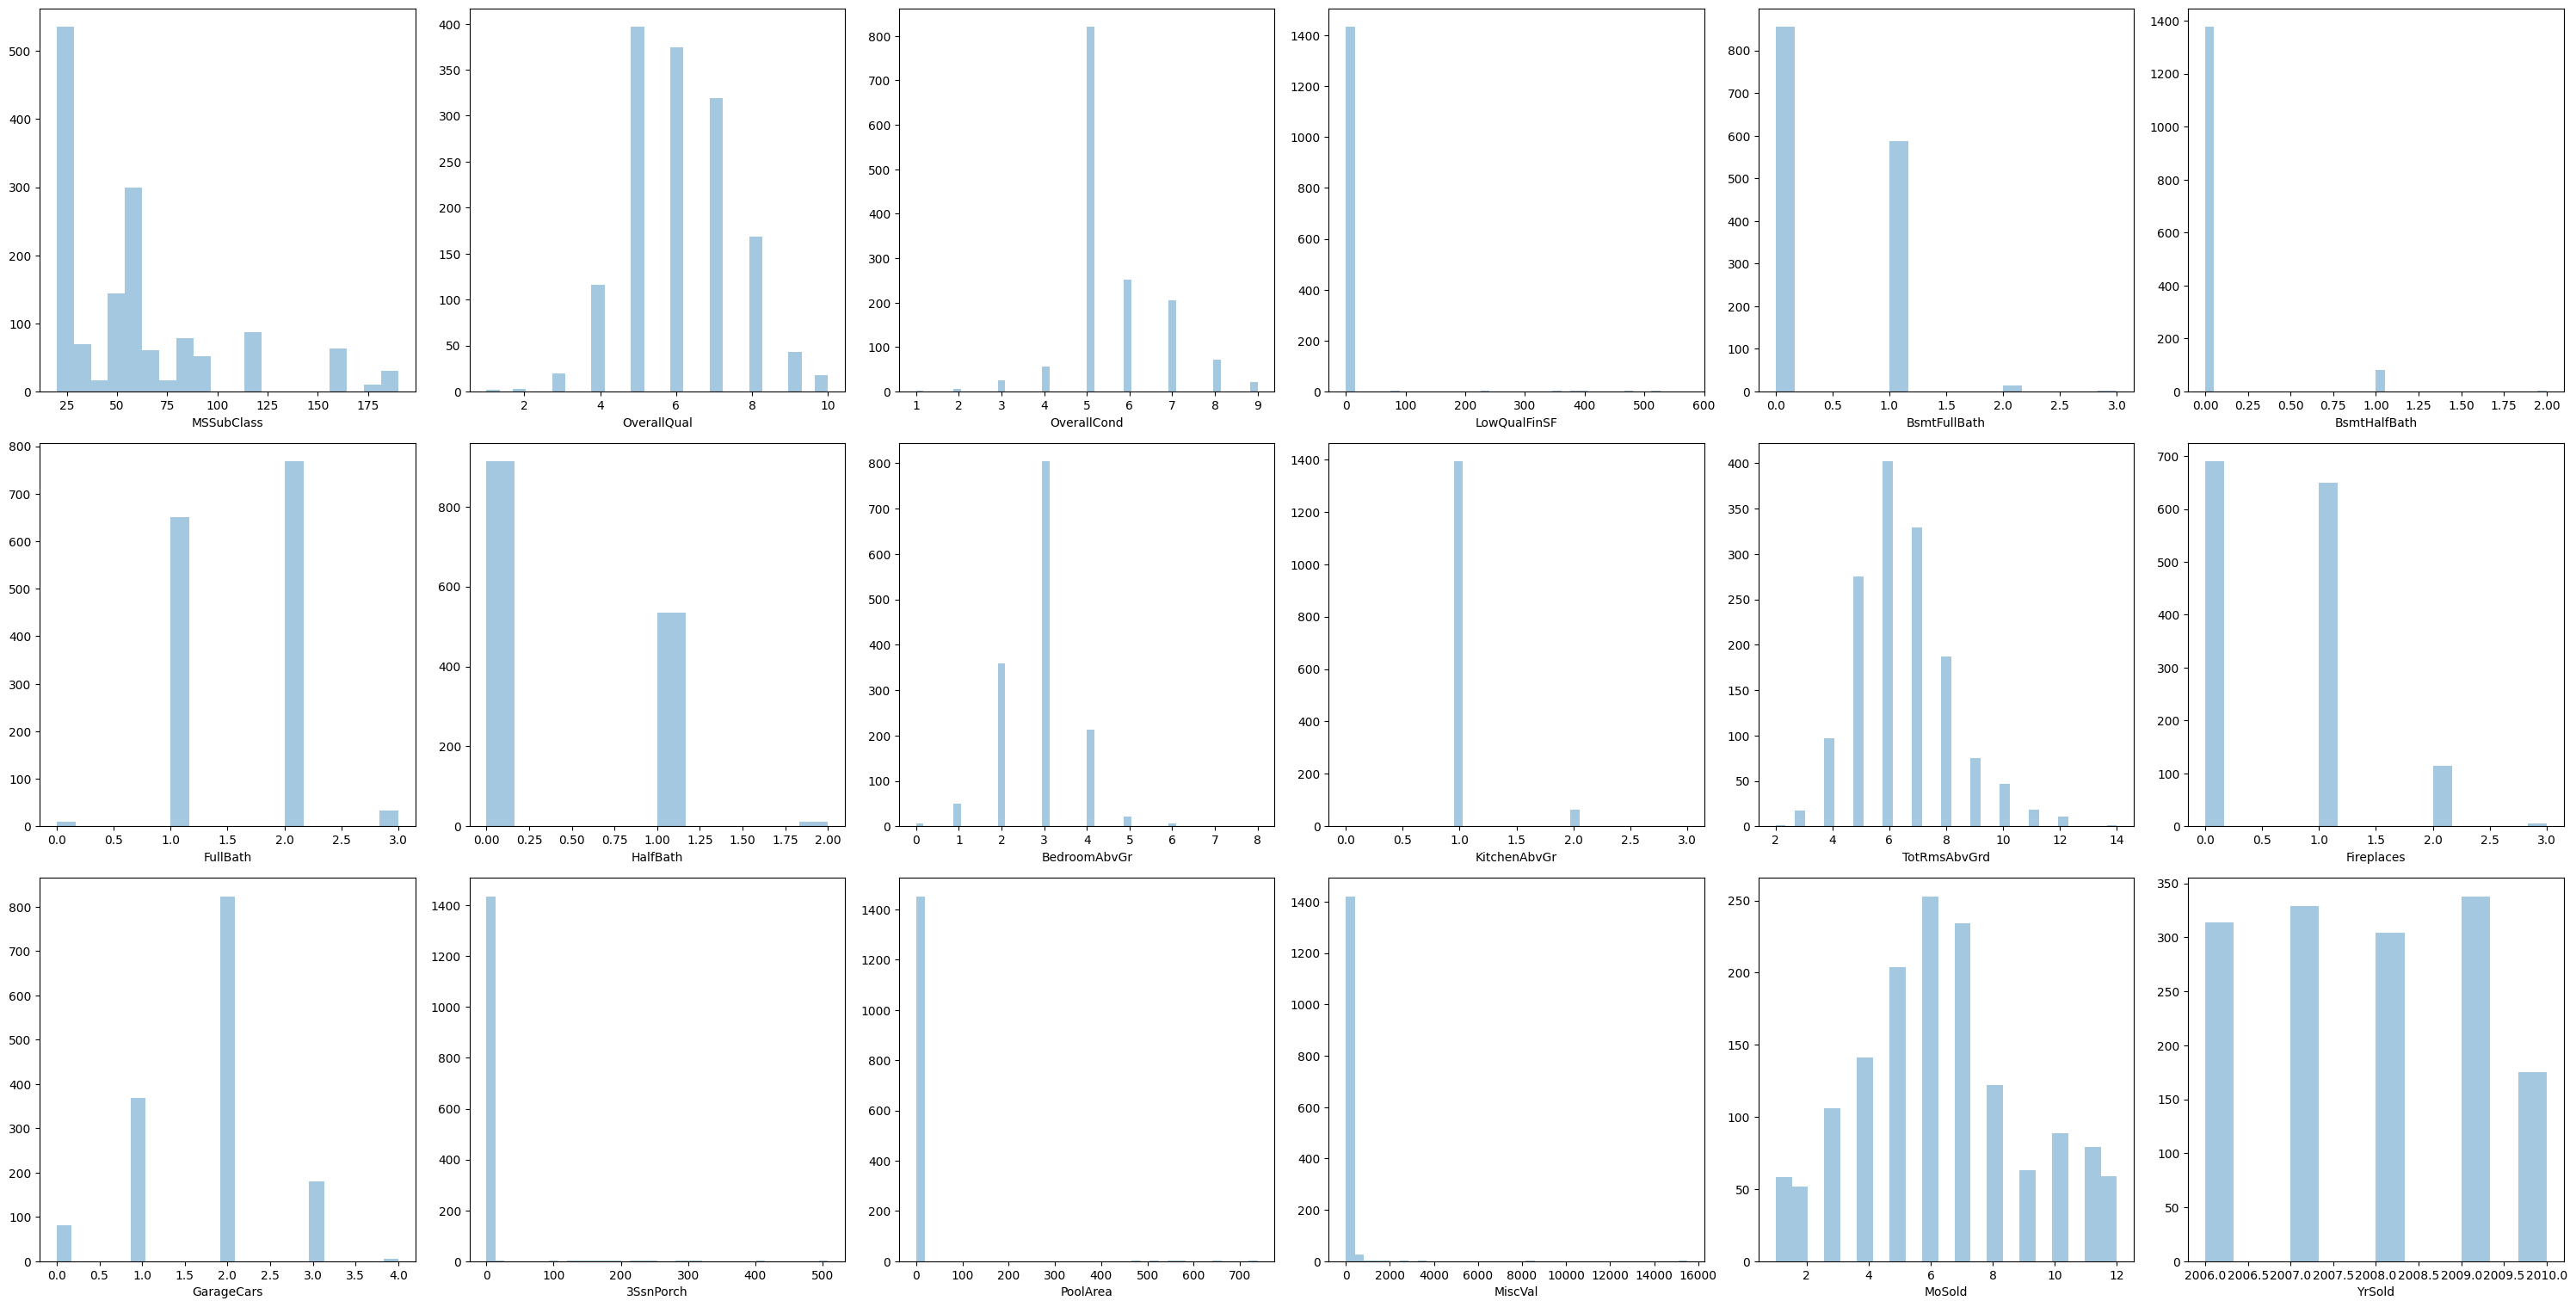

In [10]:
fig = plt.figure(figsize=(30,30))
for index,col in enumerate(train[discrete_feature]):
    plt.subplot(6,6,index+1)
    sns.distplot(train[discrete_feature].loc[:,col].dropna(), kde=False)
    if index+1 > len(numerical_feature):
        pass
fig.tight_layout(pad=1.0)

#### Variables with mostly 1 value as seen from the plots above that are candidates to drop:

| Single Value Columns to Drop |
|------------------------------|
| BsmtFinSF2                   |
| LowQualFinSF                 |
| EnclosedPorch                |
| 3SsnPorch                    |
| ScreenPorch                  |
| PoolArea                     |
| MiscVal                      |

#### Check if numerical columns have more than 96% of the same value, if so, remove them.

In [11]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

print("Numerical Features with >96% of the same value: ",overfit_num)

Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


#### Plot categorical features to gain insights into the distributions

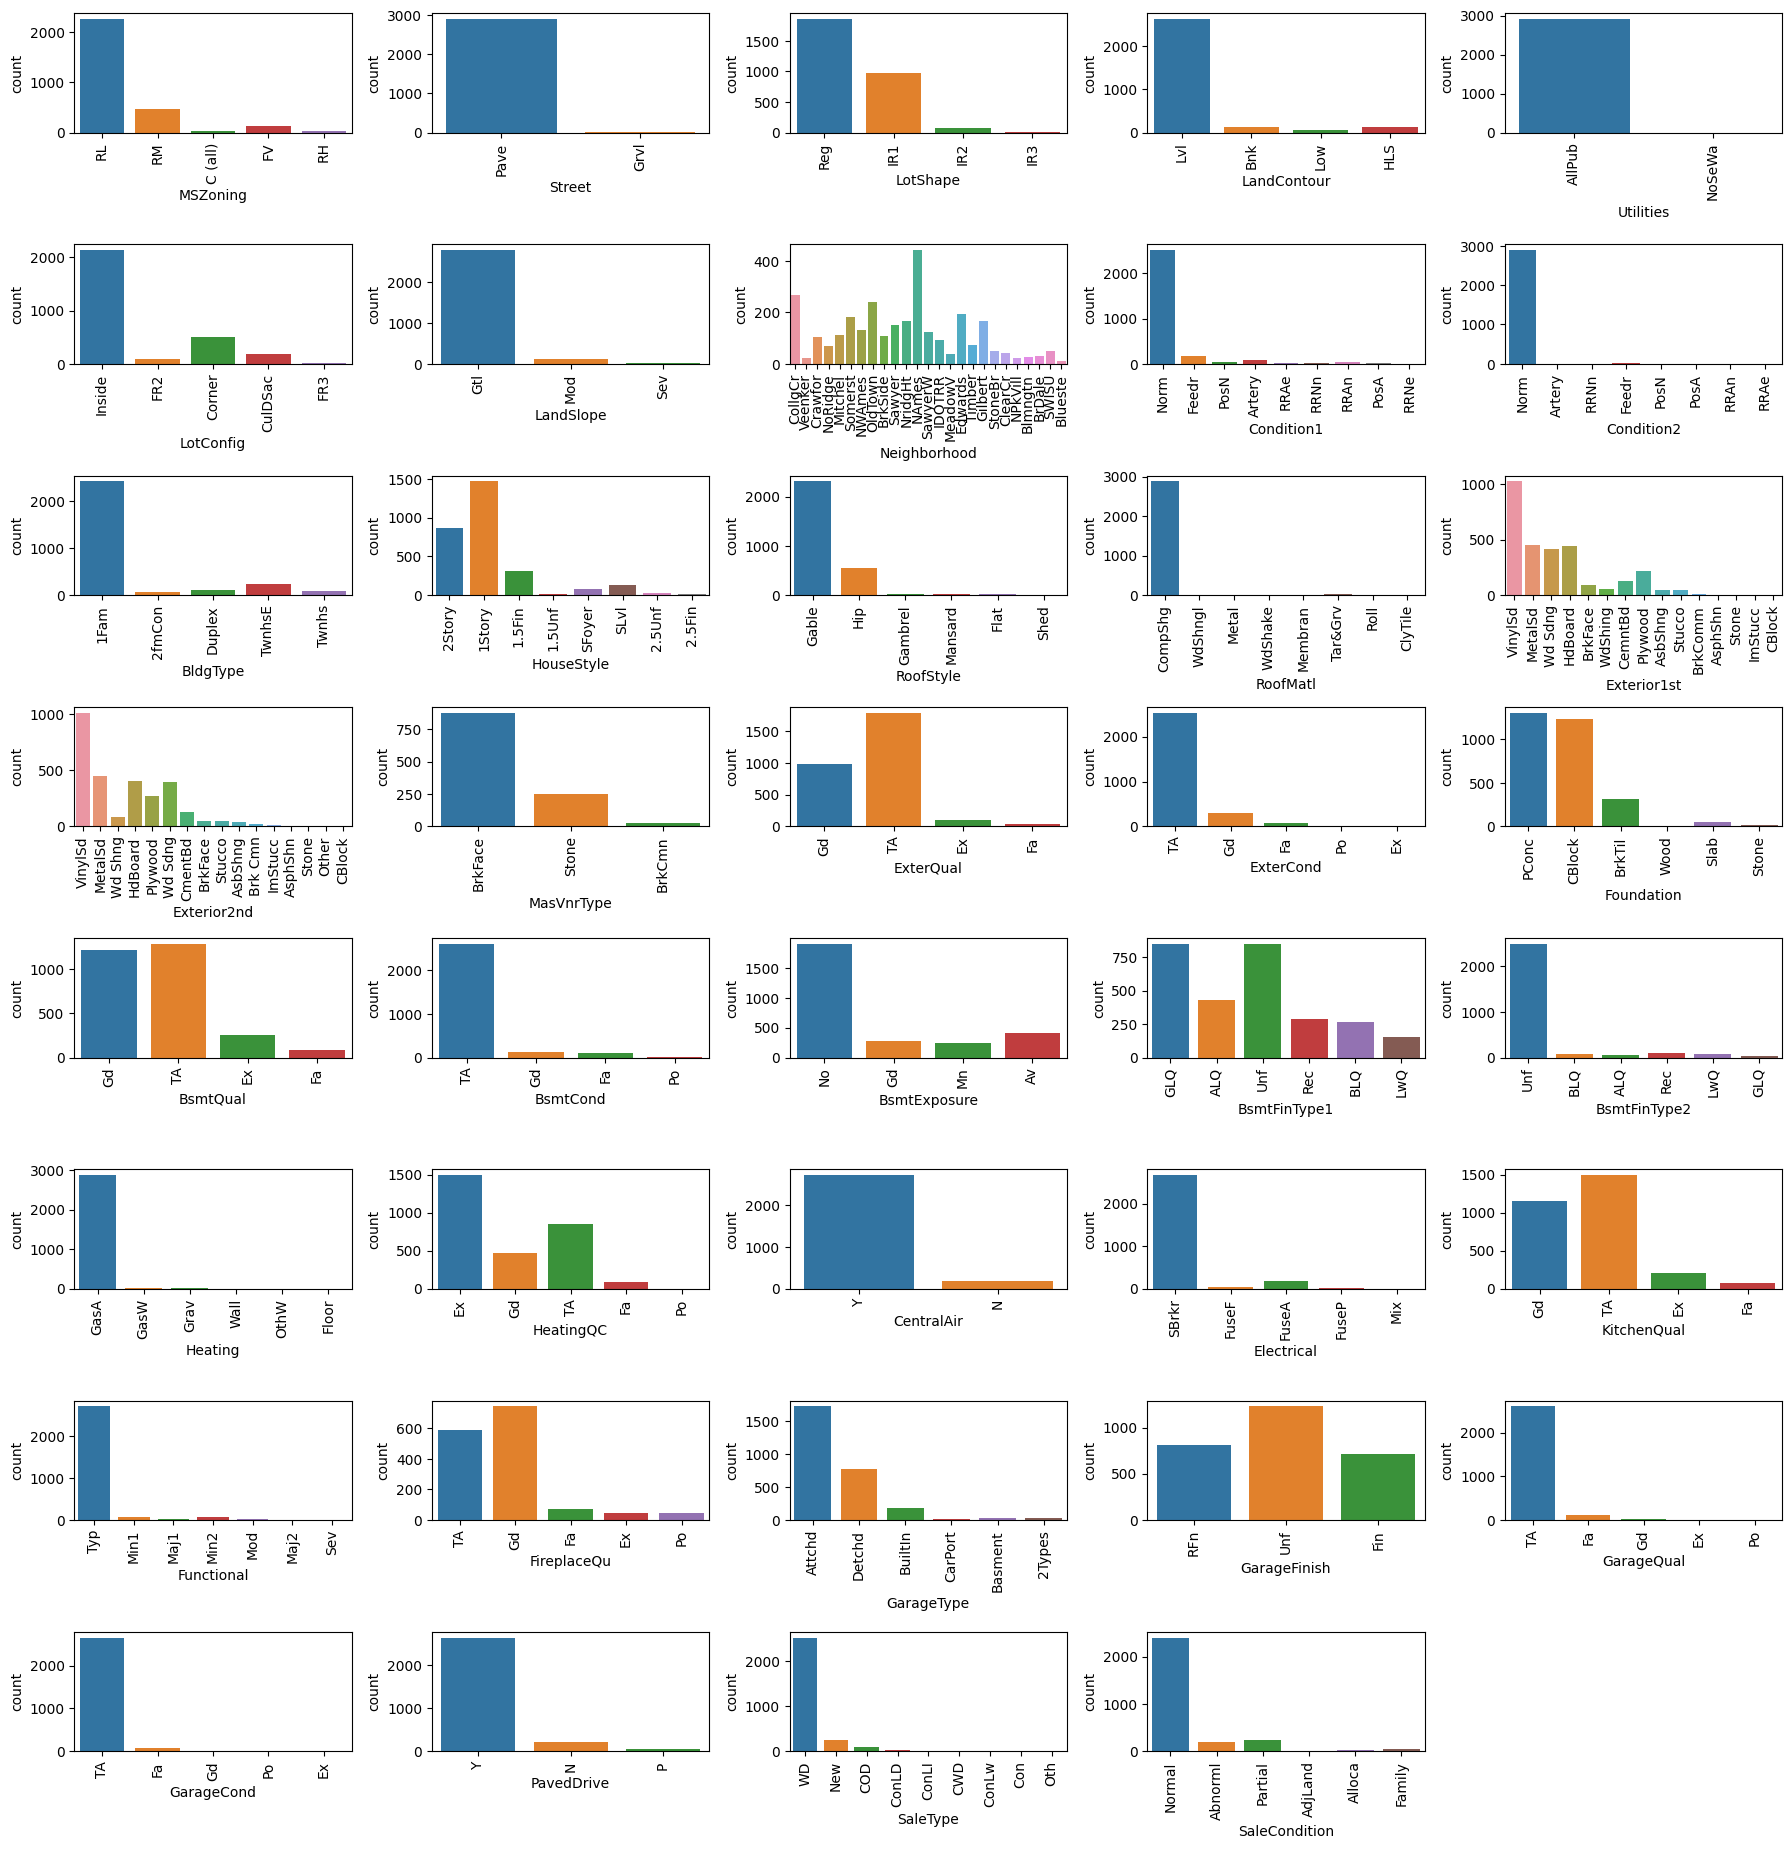

In [12]:
cat = X.select_dtypes(include=['object']).copy()
fig = plt.figure(figsize=(18,20))
for index in range(len(cat.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat.iloc[:,index], data=cat.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

#### Check if categorical columns have more than 96% of the same value, if so, remove them.

In [13]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)
print("Categorical Features with >96% of the same value: ",overfit_cat)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']


#### Create a heatmap to discover which features have a correlation greater than 80%. 

<Axes: >

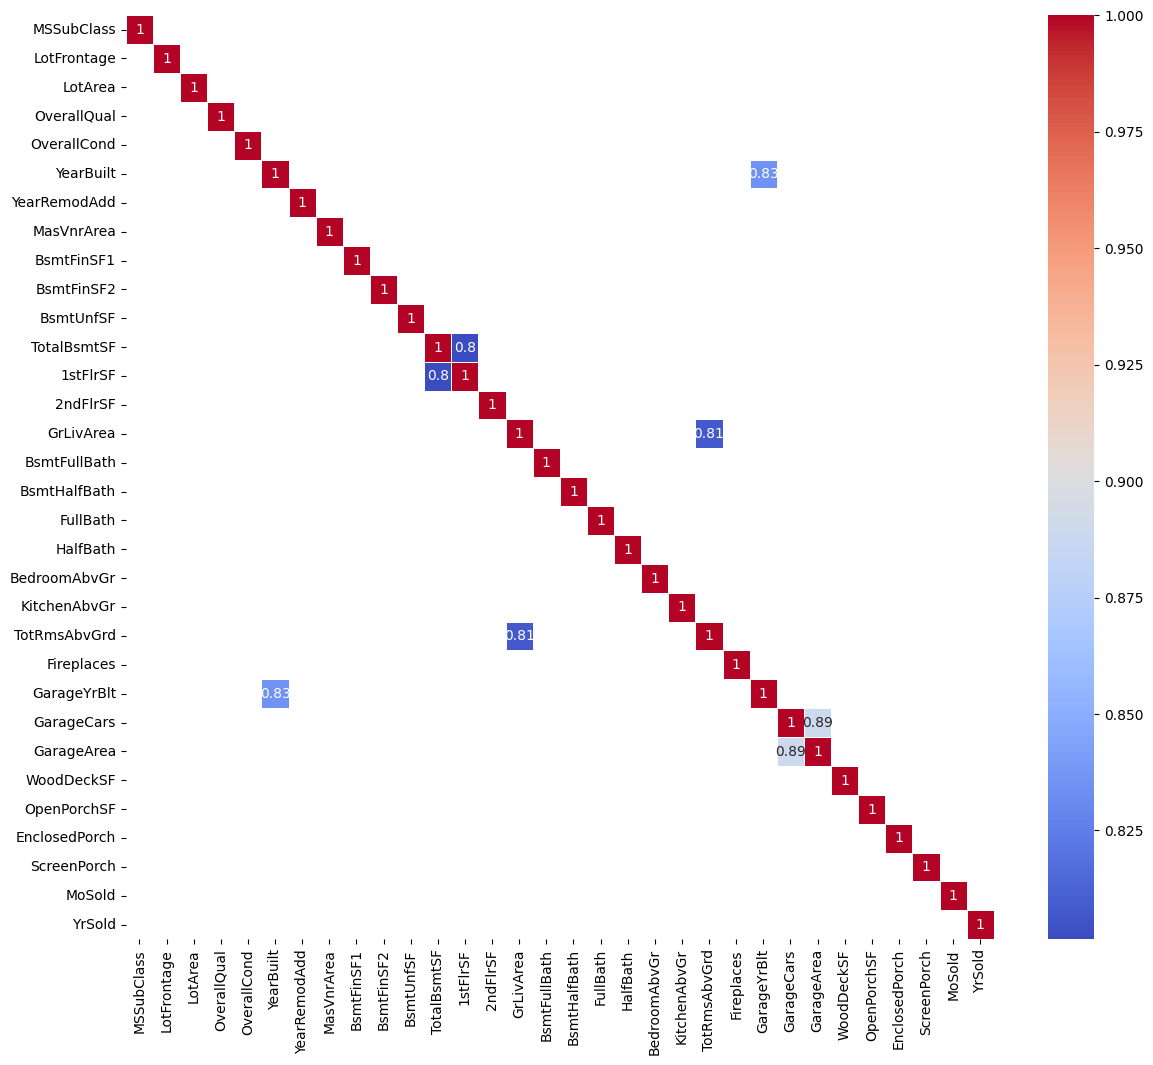

In [14]:
numeric = X.select_dtypes(exclude=['object']).copy()
plt.figure(figsize=(14,12))
correlation = numeric.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='coolwarm',annot=True, fmt='.2g')

### Highly Correlated Variables:

##### GarageYrBlt and YearBuilt
##### TotRmsAbvGrd and GrLivArea
##### 1stFlrSF and TotalBsmtSF
##### GarageArea and GarageCars

#### To avoid multicollinearity issues, we will remove GarageYrBlt, TotRmsAbvGrd, 1stFlrSF, and GarageCars

In [15]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

#### Replot correlation matrix to ensure highly correlated columns were removed. 

<Axes: >

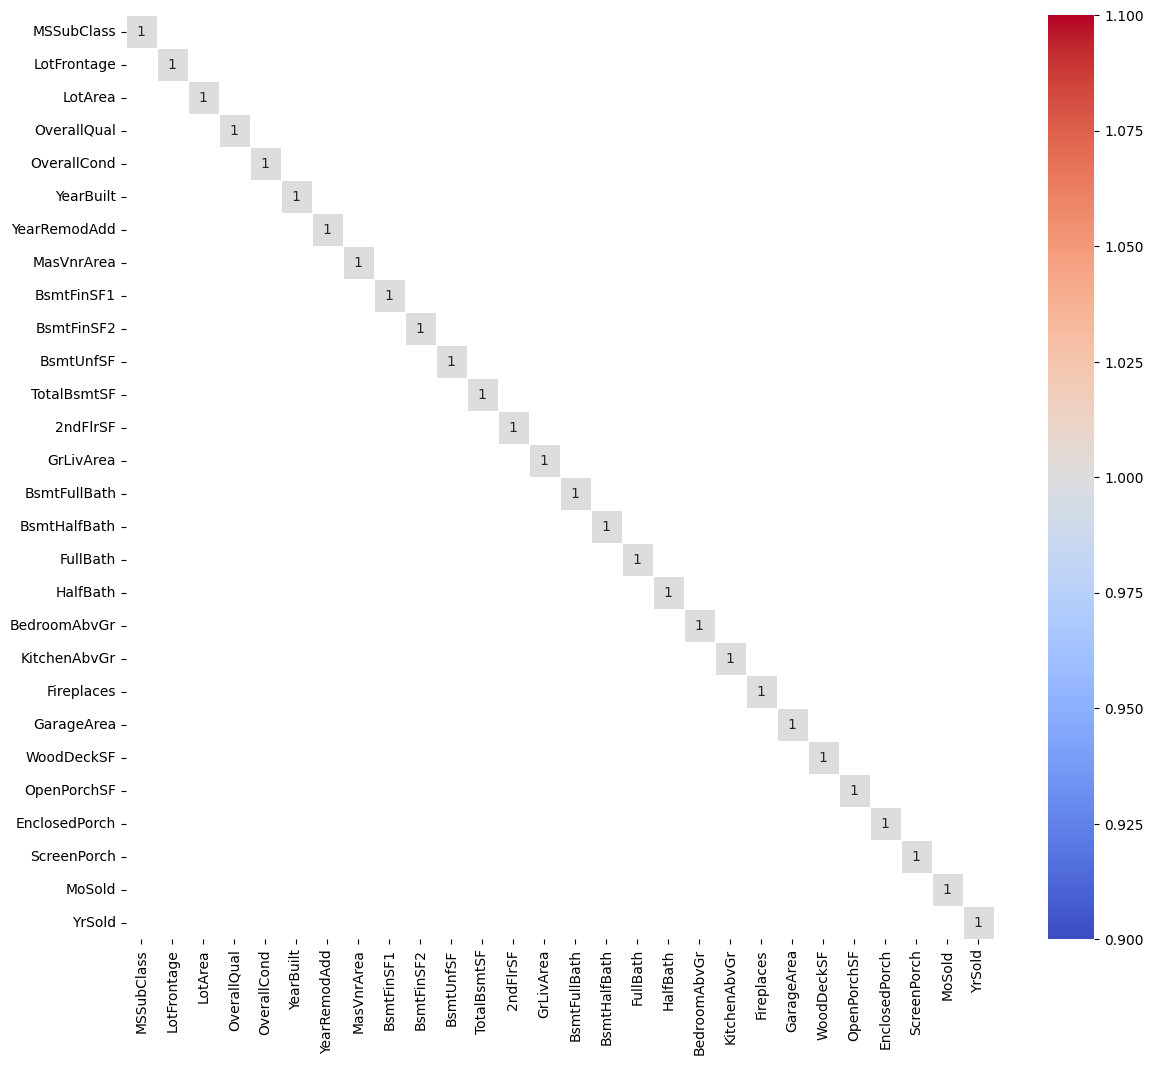

In [16]:
numeric = X.select_dtypes(exclude=['object']).copy()
plt.figure(figsize=(14,12))
correlation = numeric.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='coolwarm', annot=True, fmt='.2g')

#### Plot features versus SalePrice to gain insights on feature relationships and spot outliers

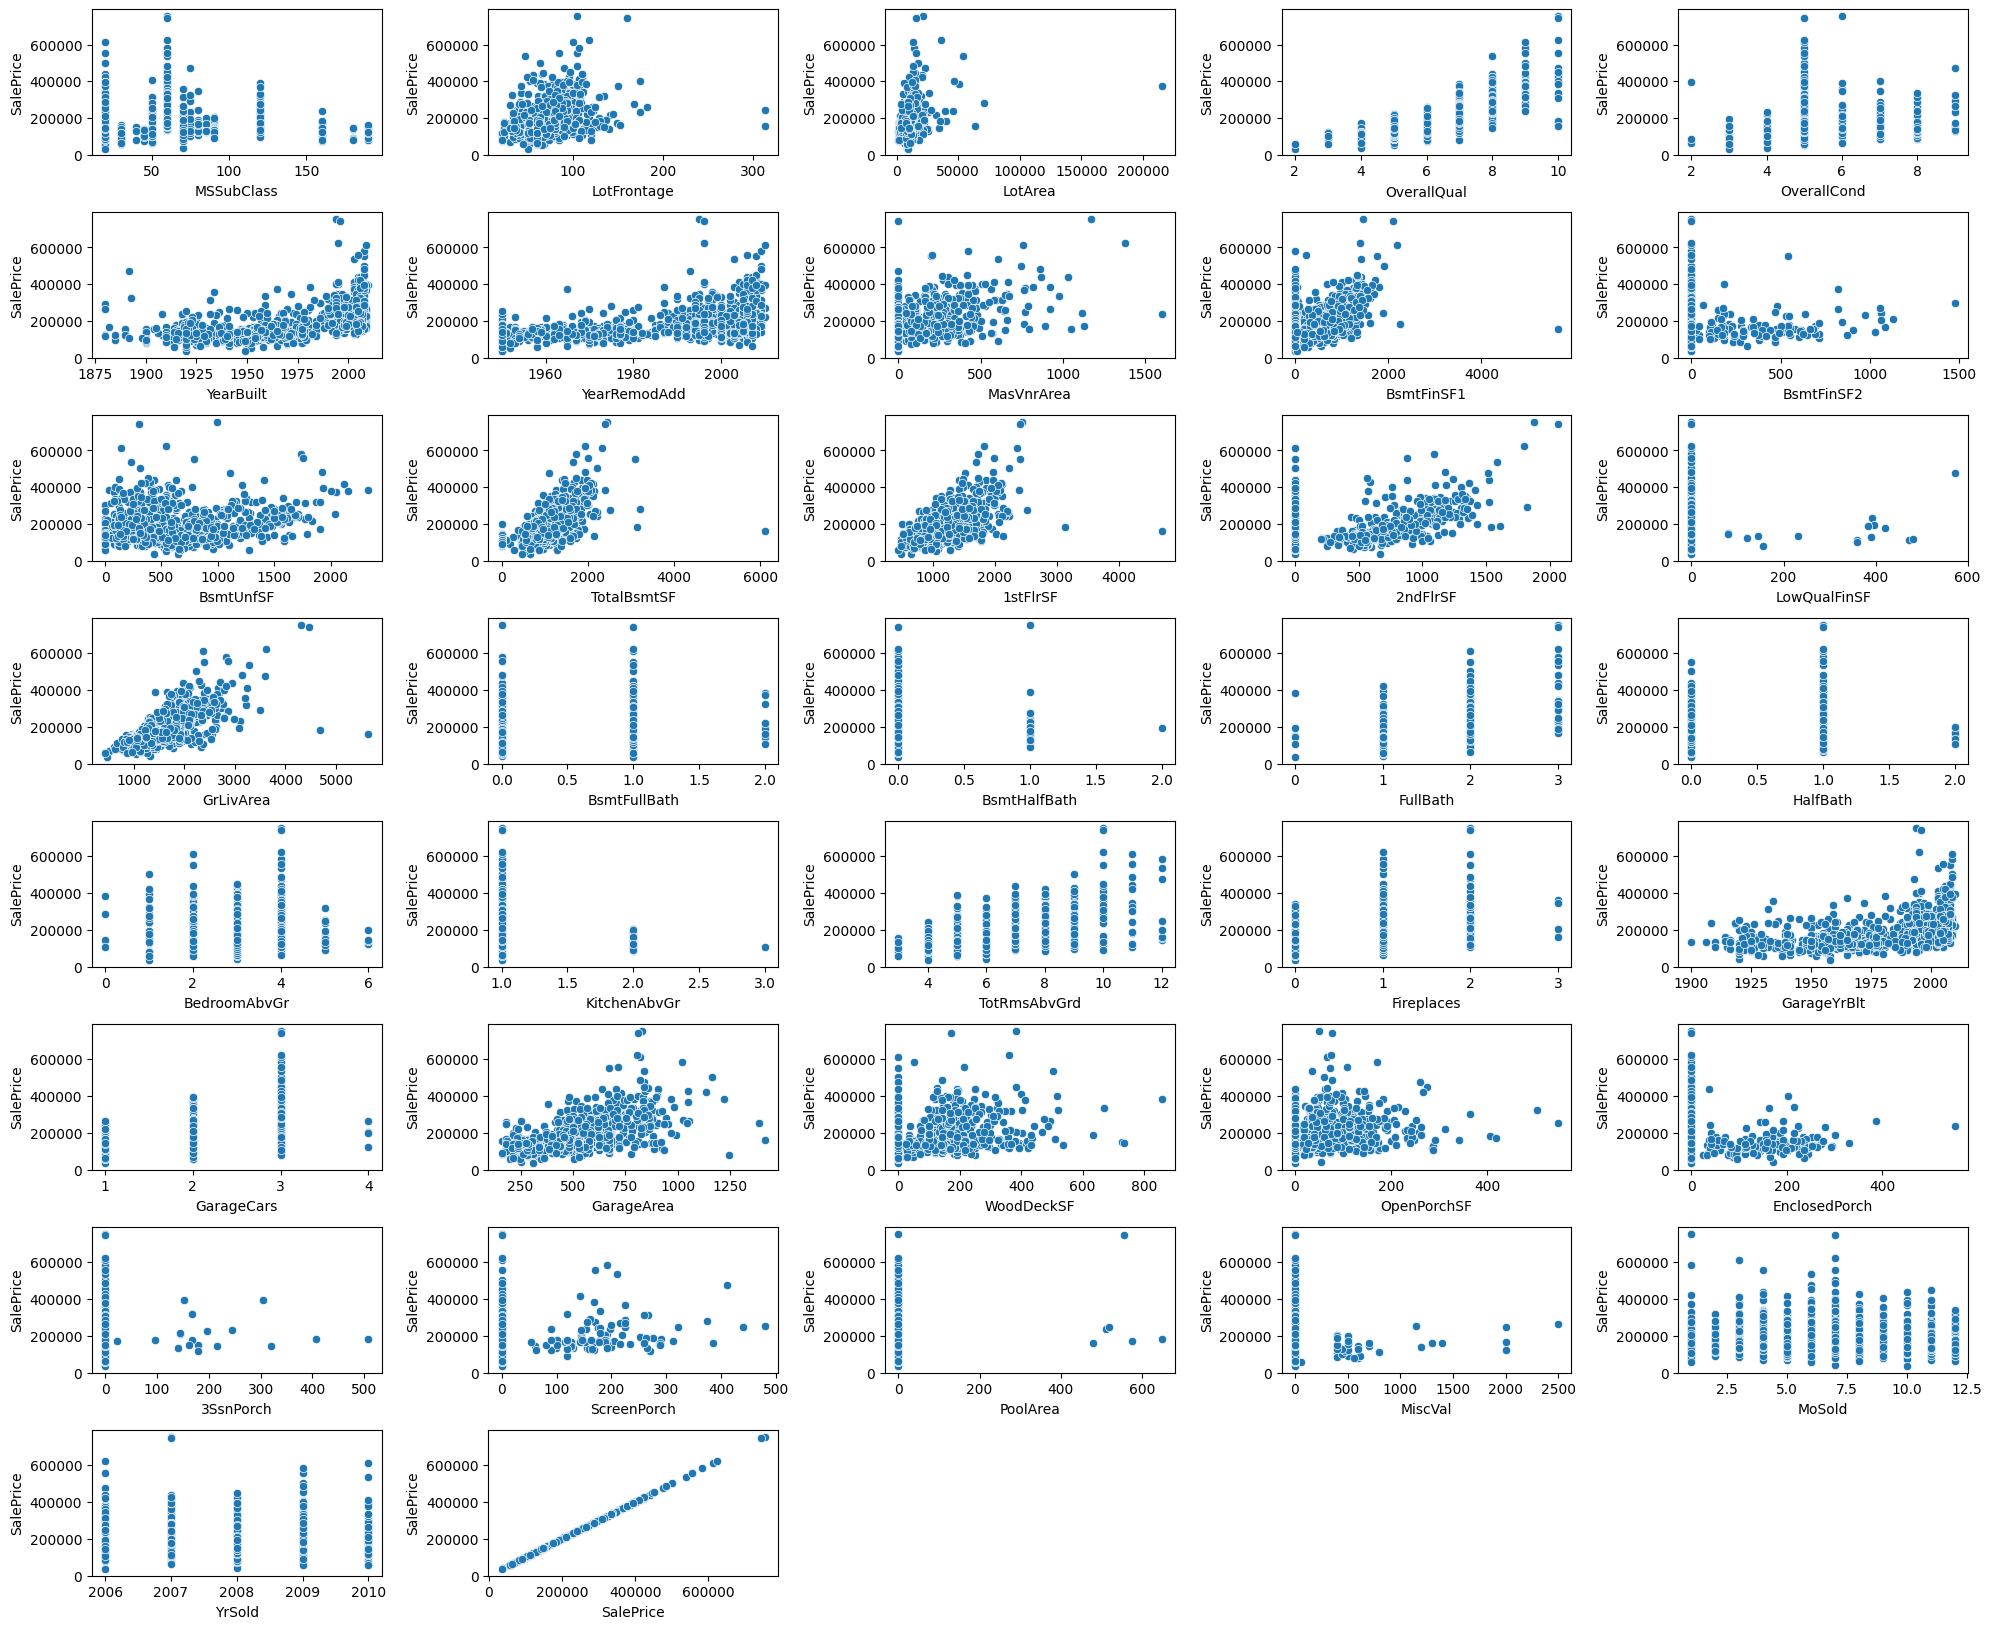

In [17]:
numeric_versus_sales = train.select_dtypes(exclude=['object']).copy()
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_versus_sales.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_versus_sales.iloc[:,index], y='SalePrice', data=numeric_versus_sales.dropna())
fig.tight_layout(pad=1.0)

#### Create boxplots to clearly identify numerical outliers

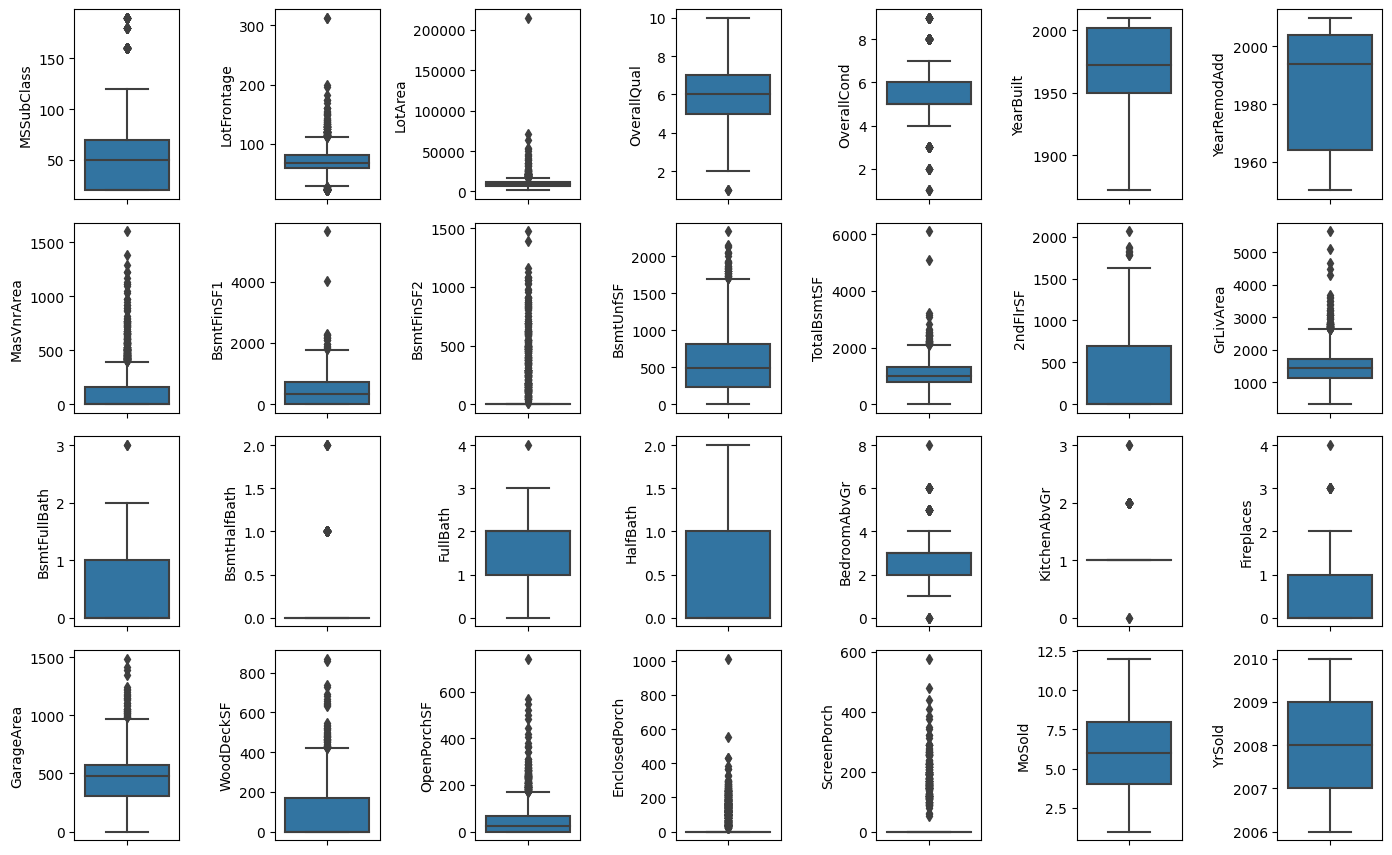

In [18]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(numeric):
    plt.subplot(7,7,index+1)
    sns.boxplot(y=col, data=numeric.dropna())
    if index+1 > len(numeric):
        pass
fig.tight_layout(pad=1.0)

#### Zoom in on some features with extreme outliers

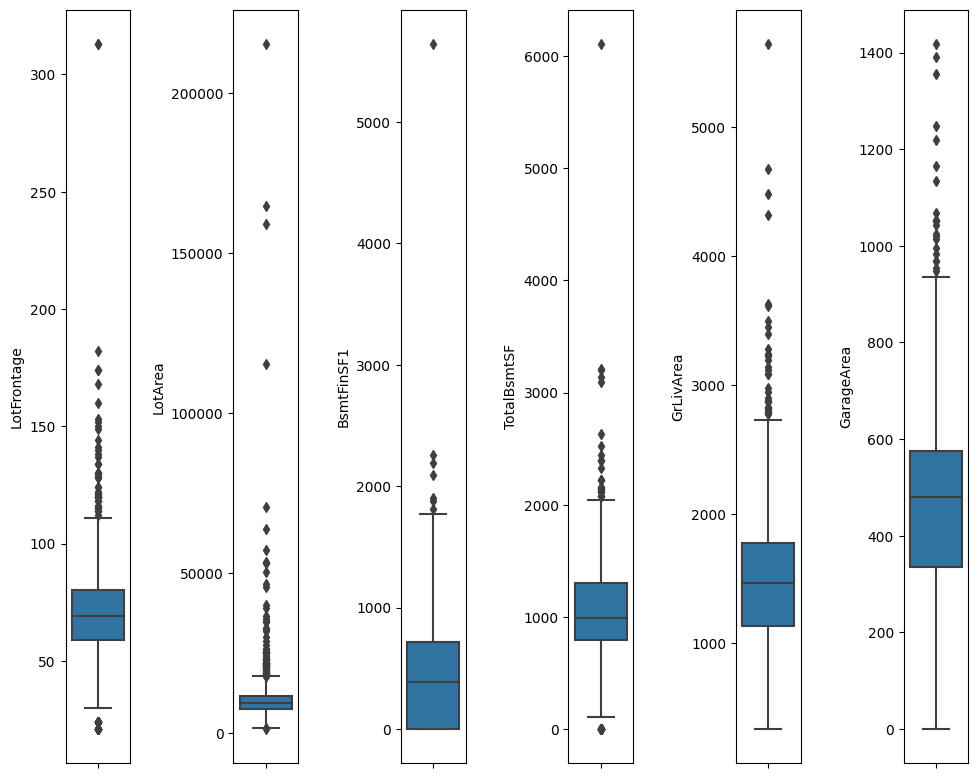

In [19]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea']
fig = plt.figure(figsize=(10,8))
for index,col in enumerate(out_col):
    plt.subplot(1,6,index+1)
    sns.boxplot(y=col, data=train)
fig.tight_layout(pad=1.5)

#### Removing outliers will prevent our models performance from being affected by extreme values.
#### From the boxplots above, here are some columns to set thresholds to remove extreme outliers: LotFrontage, LotArea, BsmtFinSF1, TotalBsmtSF, GrLivArea

In [20]:
#Drop outliers based on thresholds
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index)
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['TotalBsmtSF'] > 4000) & (train['SalePrice'] < 200000)].index)
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 50000].index)
train = train.drop(train[train['BsmtFinSF1'] > 3000].index)

#### Remove to ensure outliers are removed

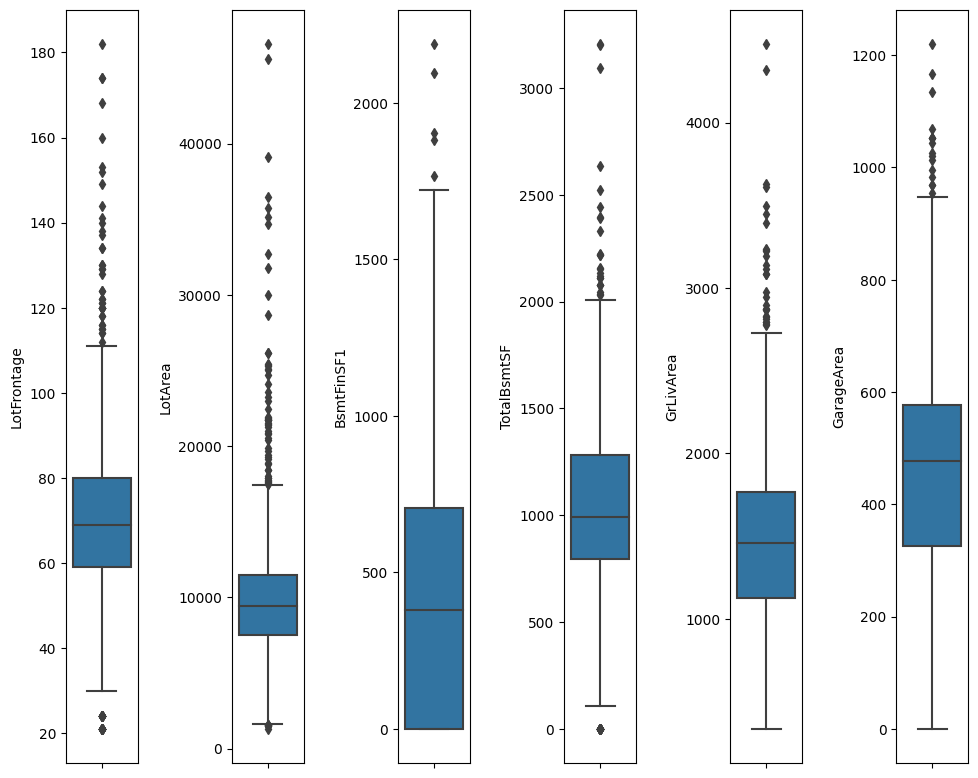

In [21]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea']
fig = plt.figure(figsize=(10,8))
for index,col in enumerate(out_col):
    plt.subplot(1,6,index+1)
    sns.boxplot(y=col, data=train)
fig.tight_layout(pad=1.5)

#### Review columns with missing values that need to be processed.

In [22]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

sum
MasVnrType    1766
FireplaceQu   1420
LotFrontage    486
GarageCond     159
GarageQual     159
GarageFinish   159
GarageType     157
BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
MasVnrArea      23
MSZoning         4
Functional       2

## **Imputing Categorical Features**

#### Ordinal (Categorical) Features features with missing values will be filled with "NA" then replaced with the mode of the column. The mode representing the most frequency appearing term that each column has. Grouping by the Neighborhood first to determine the mode of the local area for each column. 

In [23]:
#categorical to be filled with NA only
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")
X[cat].isnull().sum()

GarageType      0
GarageFinish    0
BsmtFinType2    0
BsmtExposure    0
BsmtFinType1    0
GarageCond      0
GarageQual      0
BsmtCond        0
BsmtQual        0
FireplaceQu     0
KitchenQual     0
HeatingQC       0
ExterQual       0
ExterCond       0
dtype: int64

In [24]:
#categorical filled with mode
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else X[col].mode()[0]))
X[cols].isnull().sum()

MasVnrType     0
MSZoning       0
Exterior1st    0
Exterior2nd    0
SaleType       0
Electrical     0
Functional     0
dtype: int64

## **Imputing Numerical Features**

#### Common practice is to impute with the mean of the feature distribution. 

#### However, for imputing the numerical features in this dataset, the missing values will be imputed based off the mean of the features distribution in relation to the Neighborhood. This is to calculate local means within the dataset. This is due to wide variance within the distributions. 

#### For instance, certain features like LotFrontage and GarageArea have wide variance in their distribution. 
#### View the means of these two features across the different Neighborhoods to see the distribution of means. 

In [25]:
print("Mean of LotFrontage: ", X['LotFrontage'].mean())
print("Mean of GarageArea: ", X['GarageArea'].mean())

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

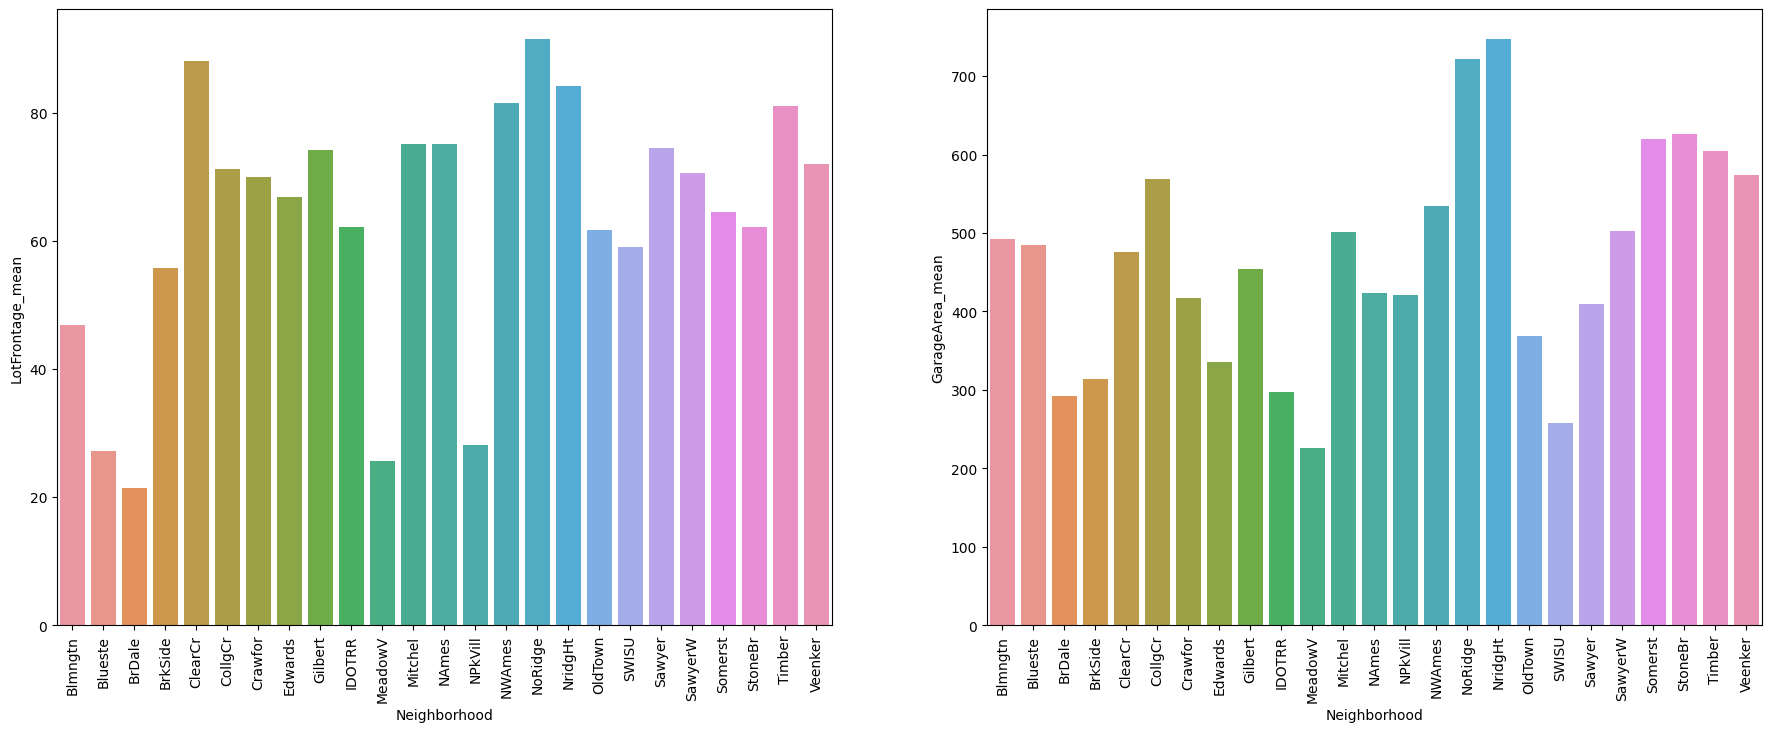

In [26]:
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [27]:
#Impute with neighboor means for wide distributed features dependent on locality.
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))

## **Special Feature Considerations**

#### **MSZoning** and **MSSubClass** are categorical even though MSZoning is numerical. Thus, for imputing MSZoning, we will group by MSSubclass first then take the mode. 
#### For MSSubClass, we will make it a string so it is viewed as categorical. 

<p style="text-align: center;">
MSZoning: Identifies the general zoning classification of the sale.
</p>

|Val | MSZoning                     |
|----|------------------------------|
| A  | Agriculture                  |
| C  | Commercial                   |
| FV | Floating Village Residential |
| I  | Industrial                   |
| RH | Residential High Density     |
| RL | Residential Low Density      |
| RP | Residential Low Density Park |
| RM | Residential Medium Density   |

<p style="text-align: center;">
MSSubClass: Identifies the type of dwelling involved in the sale.	
</p>

| Val  | MSSubClass                                            |
|------|-------------------------------------------------------|
| 20   | 1-STORY 1946 & NEWER ALL STYLES                       |
| 30   | 1-STORY 1945 & OLDER                                  |
| 40   | 1-STORY W/FINISHED ATTIC ALL AGES                     |
| 45   | 1-1/2 STORY - UNFINISHED ALL AGES                     |
| 50   | 1-1/2 STORY FINISHED ALL AGES                         |
| 60   | 2-STORY 1946 & NEWER                                  |
| 70   | 2-STORY 1945 & OLDER                                  |
| 75   | 2-1/2 STORY ALL AGES                                  |
| 80   | SPLIT OR MULTI-LEVEL                                  |
| 85   | SPLIT FOYER                                           |
| 90   | DUPLEX - ALL STYLES AND AGES                          |
| 120  | 1-STORY PUD (Planned Unit Development) - 1946 & NEWER |
| 150  | 1-1/2 STORY PUD - ALL AGES                            |
| 160  | 2-STORY PUD - 1946 & NEWER                            |
| 180  | PUD - MULTILEVEL - INCL SPLIT LEV/FOYER               |
| 190  | 2 FAMILY CONVERSION - ALL STYLES AND AGES             |


In [28]:
#Impute missing values in MSZoning and transform MSSubClass to string
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
X['MSSubClass'] = X['MSSubClass'].apply(str)

In [29]:
#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont] = X[cont].fillna(X[cont].mean())
X[cont].isnull().sum()

BsmtHalfBath    0
BsmtFullBath    0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
MasVnrArea      0
dtype: int64

## **Mapping Ordinal Features**

#### Ordinal features such as quality of the house being fair, good, great will be mapped numerical for our machine learning algorithm to process. 

#### I decided to remove the fence feature since there were so many missing values. I commented out the mapping below. 

In [30]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}

#fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [31]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)

#X['Fence'] = X['Fence'].map(fence_map)

## **Feature Engineering**

#### Creating additional features to aid in predicting the target variable: SalePrice 

#### New features include summing of the total surface area inside and outside of the house and determining the overall quality of the usable living area. 

In [32]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['Total_Close_Live_Area'] = X['GrLivArea'] + X['TotalBsmtSF'] 
X['Outside_live_area'] =  X['WoodDeckSF'] + X['OpenPorchSF'] + X['EnclosedPorch']+ X['ScreenPorch']
X['Total_usable_area'] = X['Total_Close_Live_Area'] + X['Outside_live_area']
X['Area_Quality_Indicator'] = X['Total_usable_area'] * X['OverallQual']
X['Area_Qual_Cond_Indicator'] = X['Total_usable_area'] * X['OverallQual']* X['OverallCond']

## **Binary Columns Feature Engineering**

#### Including some binary columns to feed the algorithm as to whether certain features exist or not. 
#### For instance, does this house have a second floor? Yes (1) or No (0). 

In [33]:
column = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF']

for col in column:
    col_name = col+'_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)

## **One Hot Encoding**

#### Using Pandas get_dummies to convert the categorical features into numerical. 
#### ML requires numerical values. 

In [34]:
X = pd.get_dummies(X)
X

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                              
1            65.0     8450            7            5       2003          2003   
2            80.0     9600            6            8       1976          1976   
3            68.0    11250            7            5       2001          2002   
4            60.0     9550            7            5       1915          1970   
5            84.0    14260            8            5       2000          2000   
...           ...      ...          ...          ...        ...           ...   
2915         21.0     1936            4            7       1970          1970   
2916         21.0     1894            4            5       1970          1970   
2917        160.0    20000            5            7       1960          1996   
2918         62.0    10441            5            5       1992          1992   
2919         74.0     9627            7            5       1993          1994   

      MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  \
Id                                                                         
1          196.0          4          3         4         3             1   
2            0.0          3          3         4         3             4   
3          162.0          4          3         4         3             2   
4            0.0          3          3         3         4             1   
5          350.0          4          3         4         3             3   
...          ...        ...        ...       ...       ...           ...   
2915         0.0          3          3         3         3             1   
2916         0.0          3          3         3         3             1   
2917         0.0          3          3         3         3             1   
2918         0.0          3          3         4         3             3   
2919        94.0          3          3         4         3             3   

      BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
Id                                                                    
1                6       706.0             1         0.0      150.0   
2                5       978.0             1         0.0      284.0   
3                6       486.0             1         0.0      434.0   
4                5       216.0             1         0.0      540.0   
5                6       655.0             1         0.0      490.0   
...            ...         ...           ...         ...        ...   
2915             1         0.0             1         0.0      546.0   
2916             3       252.0             1         0.0      294.0   
2917             5      1224.0             1         0.0        0.0   
2918             6       337.0             1         0.0      575.0   
2919             2       758.0             1         0.0      238.0   

      TotalBsmtSF  HeatingQC  2ndFlrSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
1           856.0          5       854       1710           1.0           0.0   
2          1262.0          5         0       1262           0.0           1.0   
3           920.0          5       866       1786           1.0           0.0   
4           756.0          4       756       1717           1.0           0.0   
5          1145.0          5      1053       2198           1.0           0.0   
...           ...        ...       ...        ...           ...           ...   
2915        546.0          4       546       1092           0.0           0.0   
2916        546.0          3       546       1092           0.0           0.0   
2917       1224.0          5         0       1224           1.0           0.0   
2918        912.0          3         0        970           0.0           1.0   
2919        996.0          5      1004       2000           0.0    

### **Sale Price Skewness**

#### Since the sale price is positively skewed to the right, we will alleviate by taking the log transform of the skewed target. 

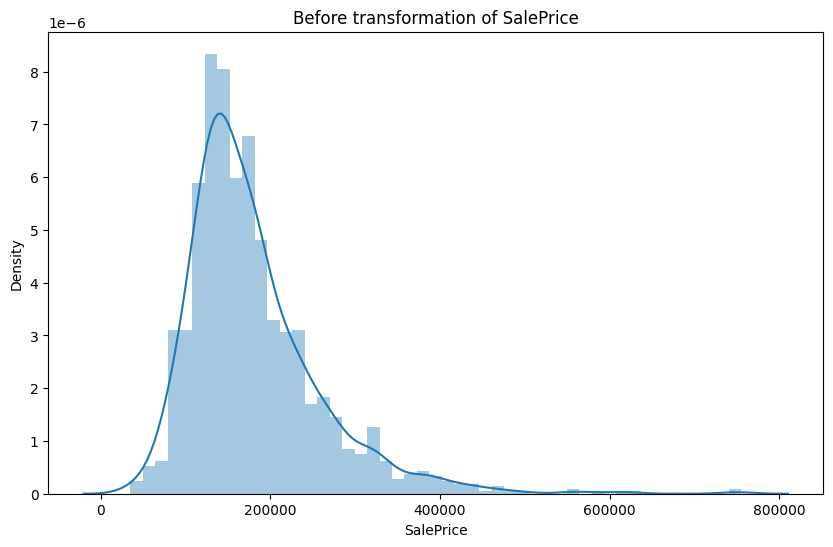

In [35]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'],norm_hist=False)

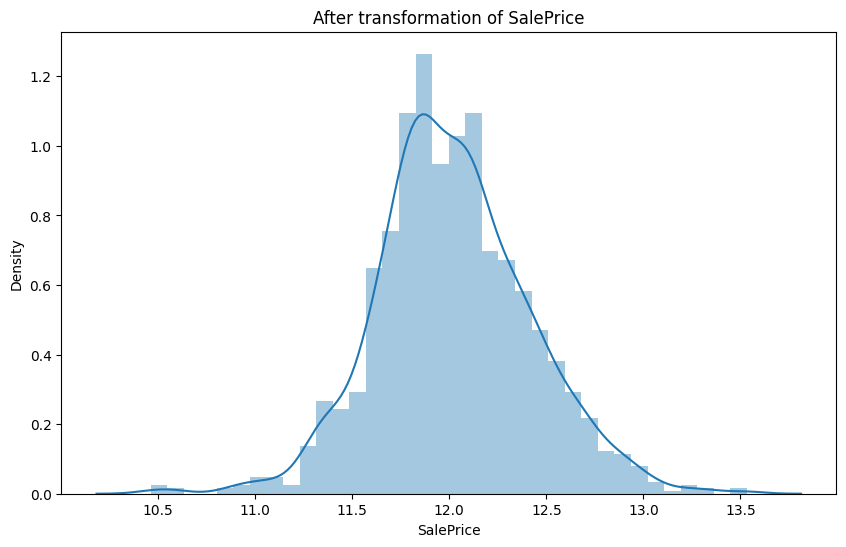

In [36]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [37]:
y["SalePrice"] = np.log(y['SalePrice'])

In [38]:
x = X.loc[train.index]
y = y.loc[train.index]
X_test = X.loc[test.index]

## **Standardization**

#### Standardization data with RobustScaler since this scaler handles outliers well.
#### This Scaler removes the median and scales the data according to the Interquartile Range (IQR). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [39]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
X_test[cols] = transformer.transform(X_test[cols])

In [40]:
pd.DataFrame(x.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(5)

sum
LotFrontage            0
Exterior2nd_Stucco     0
Exterior1st_AsphShn    0
Exterior1st_BrkComm    0
Exterior1st_BrkFace    0

In [41]:
from sklearn.model_selection import train_test_split

import pandas as pd

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [42]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1155, 227)
Series([], dtype: int64)


In [43]:
# Shape of training data (num_rows, num_columns)
print(X_test.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_test.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1459, 227)
Series([], dtype: int64)


## **Keras Neutral Net Architecture**

#### This keras neutral network architecture averages MAE around 20,000
#### Future development will be done to match the regression models performance. 
#### Regression models currently fit the data better, as shown below. 

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape=[227]

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=150, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [46]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,
)

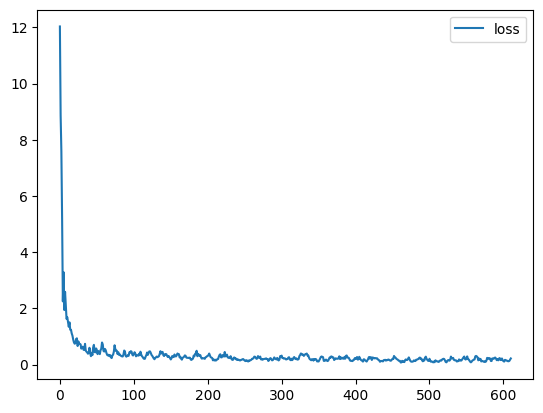

In [47]:
import pandas as pd

history_df = pd.DataFrame(history.history)
#Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[:, ['loss']].plot();

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get validation predictions and MAE
preds_valid = model.predict(X_valid)
preds_valid = np.exp(preds_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))
mae_keras_nn = round(np.log(mean_absolute_error(y_valid, preds_valid)),3)
rmse_keras_nn = round(np.sqrt(np.log(mean_squared_error(y_valid, preds_valid))),3)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MAE (Your approach):
183380.58000065753


In [49]:
# Fill in the line below: get test predictions
preds_test = model.predict(X_test)
preds_test_flat = preds_test.flatten()
preds_test_flat = np.exp(preds_test_flat)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### Due to the stark difference in performance, I kept the Keras Neutral Net separate and not included in the Ensembled model. 
#### Simply uncomment the cell below to used the Neutral Net as the model used to make predictions for submission. 

In [50]:
# Save test predictions to file
#output = pd.DataFrame({'Id': X_test.index,
#                       'SalePrice': preds_test_flat})
#output.to_csv('submission.csv', index=False)

## **Lazy Predict**
#### I used Lazy Predict to determine big picture which regression models would work well. 
#### Initally Huber was shown to be effective, but consistently had large MAE compared to the other regression models and is not used in the ensembled model. 

In [51]:
%%capture
!pip install lazypredict

In [52]:
from lazypredict.Supervised import LazyRegressor

# build lazy predict to find overall of models
x_train_lazy , x_test_lazy , y_train_lazy , y_test_lazy = train_test_split(X_train, y_train, test_size=0.2, random_state=12, shuffle=True)


lazy_model = LazyRegressor(verbose=0, random_state=12, regressors='all')
train_lazy , test_lazy = lazy_model.fit(x_train_lazy, x_test_lazy, y_train_lazy, y_test_lazy)
test_lazy

100%|██████████| 42/42 [00:06<00:00,  6.78it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4414
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 53
[LightGBM] [Info] Start training from score 12.013271


Adjusted R-Squared   R-Squared   RMSE  \
Model                                                                  
LassoLarsIC                                 -6.45        0.90   0.12   
PoissonRegressor                            -6.46        0.90   0.12   
LassoCV                                     -6.46        0.90   0.12   
LassoLarsCV                                 -6.46        0.90   0.12   
ElasticNetCV                                -6.46        0.90   0.12   
BayesianRidge                               -6.50        0.90   0.12   
RidgeCV                                     -6.56        0.90   0.12   
Ridge                                       -6.66        0.90   0.12   
GradientBoostingRegressor                   -6.68        0.90   0.12   
LinearRegression                            -6.69        0.90   0.12   
TransformedTargetRegressor                  -6.69        0.90   0.12   
LinearSVR                                   -6.70        0.90   0.12   
HuberRegressor                              -6.72        0.90   0.12   
ExtraTreesRegressor                         -7.11        0.89   0.12   
SGDRegressor                                -7.13        0.89   0.12   
LGBMRegressor                               -7.18        0.89   0.12   
HistGradientBoostingRegressor               -7.23        0.89   0.12   
TweedieRegressor                            -7.31        0.89   0.12   
GammaRegressor                              -7.33        0.89   0.12   
XGBRegressor                                -7.67        0.89   0.13   
RandomForestRegressor                       -7.75        0.89   0.13   
SVR                                         -8.03        0.88   0.13   
BaggingRegressor                            -8.26        0.88   0.13   
NuSVR                                       -8.59        0.87   0.13   
OrthogonalMatchingPursuit                   -9.23        0.87   0.14   
OrthogonalMatchingPursuitCV                 -9.23        0.87   0.14   
KNeighborsRegressor                         -9.59        0.86   0.14   
PassiveAggressiveRegressor                  -9.85        0.86   0.14   
RANSACRegressor                             -9.86        0.86   0.14   
AdaBoostRegressor                          -10.64        0.85   0.15   
LarsCV                                     -11.30        0.84   0.15   
DecisionTreeRegressor                      -18.09        0.75   0.19   
ExtraTreeRegressor                         -20.73        0.72   0.20   
Lasso                                      -76.09       -0.01   0.38   
ElasticNet                                 -76.09       -0.01   0.38   
DummyRegressor                             -76.09       -0.01   0.38   
LassoLars                                  -76.09       -0.01   0.38   
MLPRegressor                              -527.33       -5.89   0.99   
GaussianProcessRegressor                -75150.44     -979.24  11.79   
KernelRidge                             -78034.89    -1016.86  12.01   
Lars                                -333720653.12 -4352877.10 785.42   

                               Time Taken  
Model                                      
LassoLarsIC                          0.04  
PoissonRegressor                     0.02  
LassoCV                              0.13  
LassoLarsCV                          0.05  
ElasticNetCV                         0.13  
BayesianRidge                        0.05  
RidgeCV                              0.02  
Ridge                                0.02  
GradientBoostingRegressor            0.54  
LinearRegression                     0.02  
TransformedTargetRegressor           0.02  
LinearSVR                            0.12  
HuberRegressor                       0.05  
ExtraTreesRegressor                  0.66  
SGDRegressor                         0.02  
LGBMRegressor                        0.23  
HistGradientBoostingRegressor        0.51  
TweedieRegressor                     0.02  
GammaRegressor                       0.03  
XGBRegress

#### Bring in regression models

In [53]:
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import StackingRegressor 
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold

#### Capture useful and useless features

In [54]:
# Capture useful and useless features   
useless_feature = {}   # Capture coefficient values close to zero
useful_feature  = {}   # Capture high coefficient values

## **Huber Regression**

#### This is a tuned Huber model with best parameters already determined. 
#### Uncomment to determine best parameters with your own training dataset. 

In [55]:
huber = HuberRegressor()

#param_lst = {
#    'epsilon': [1.1, 1.2, 1.3, 1.35, 1.4, 1.5, 1.75, 2.0],
#    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
#    'max_iter': [50, 100, 200, 300, 400, 500, 1000]
#}

#huber_reg = RandomizedSearchCV(estimator = huber, param_distributions = param_lst,
#                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                              cv = 5)
       
#huber_search = huber_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
#best_param = huber_search.best_params_

#best_param={'max_iter': 1000, 'epsilon': 1.75, 'alpha': 1.0}

best_param= {'max_iter': 1000, 'epsilon': 1.35, 'alpha': 100.0}
huber = HuberRegressor(**best_param)

In [56]:
best_param

{'max_iter': 1000, 'epsilon': 1.35, 'alpha': 100.0}

In [57]:
huber.fit(X_train, y_train)   
preds = huber.predict(X_valid) 
preds_test_huber = huber.predict(X_test)
mae_huber = mean_absolute_error(y_valid, preds)

In [58]:
mae_huber

0.10760457408519108

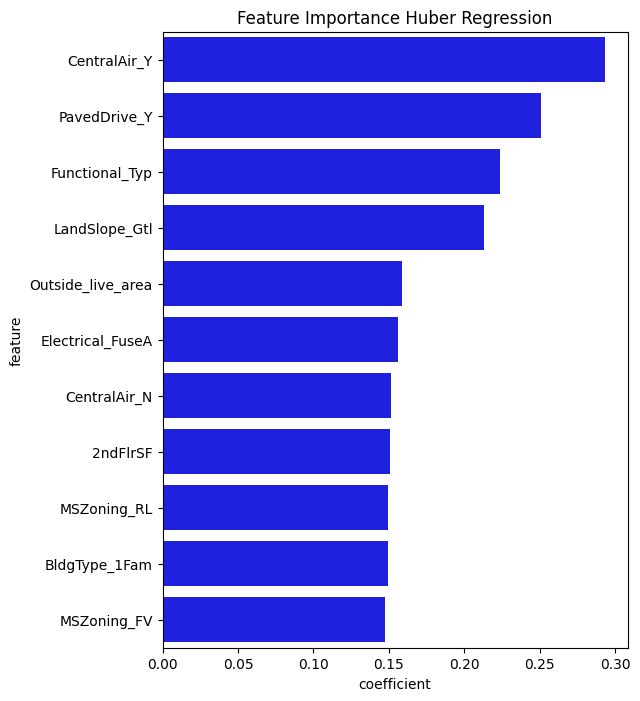

In [59]:
# check feature importance

coefficients = huber.coef_

features_importance = pd.DataFrame({
    'feature': huber.feature_names_in_,    # get feature
    'coefficient': coefficients            # get coefficient
})

features_importance['coefficient'] = abs(features_importance['coefficient'])  
features_importance = features_importance.sort_values(by='coefficient', ascending=False).reset_index(drop=True)


top_10 = features_importance.loc[:10,:]   # get top ten
plt.figure(figsize=(6,8))
sns.barplot(x= top_10['coefficient'], y= top_10['feature'], color='blue')
plt.title('Feature Importance Huber Regression')

# get useless features
zero = features_importance[features_importance['coefficient'] < 0.001 ].sort_values(by='feature', ascending=True)


# put into dictionary
for feature in zero['feature']:
    useless_feature[feature] = useless_feature.get(feature,0) + 1

# threshold for useful features
threshold = 0.02

# capture useful features
high_coef = features_importance[features_importance['coefficient'] >= threshold].sort_values(by='coefficient', ascending=False) 
high_coef = high_coef.reset_index(drop=True)

for i, feature in enumerate(high_coef['feature']):
    #access based on weight 
    useful_feature[feature] = useful_feature.get(feature, 0) + high_coef['coefficient'][i] 

## **Ridge Regression**

In [60]:
ridge = Ridge(random_state=12)

#param_lst = {
  #  'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
 #   'max_iter': [50, 100, 200, 300, 400, 500, 1000]
#}

#ridge_reg = RandomizedSearchCV(estimator = ridge, param_distributions = param_lst,
#                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                              cv = 5)
       
#ridge_search = ridge_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
#best_param = ridge_search.best_params_
best_param={'max_iter': 50, 'alpha': 10.0}
ridge = Ridge(**best_param)

In [61]:
best_param

{'max_iter': 50, 'alpha': 10.0}

In [62]:
ridge.fit(X_train, y_train)   
preds = ridge.predict(X_valid) 
preds_test_huber = ridge.predict(X_test)
mae_ridge = mean_absolute_error(y_valid, preds)

In [63]:
mae_ridge

0.07906319765707148

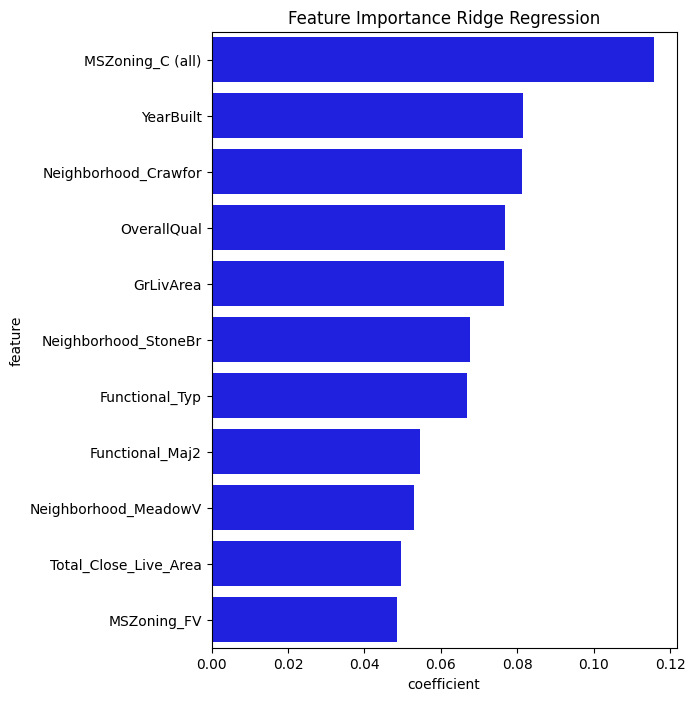

In [64]:
# check feature importance

coefficients = ridge.coef_

features_importance = pd.DataFrame({
    'feature': ridge.feature_names_in_,    # get feature
    'coefficient': coefficients.flatten()            # get coefficient
})

features_importance['coefficient'] = abs(features_importance['coefficient'])  
features_importance = features_importance.sort_values(by='coefficient', ascending=False).reset_index(drop=True)


top_10 = features_importance.loc[:10,:]   # get top ten
plt.figure(figsize=(6,8))
sns.barplot(x= top_10['coefficient'], y= top_10['feature'], color='blue')
plt.title('Feature Importance Ridge Regression')

# get useless features
zero = features_importance[features_importance['coefficient'] < 0.001 ].sort_values(by='feature', ascending=True)

# put into dictionary
for feature in zero['feature']:
    useless_feature[feature] = useless_feature.get(feature,0) + 1

# threshold for useful features
threshold = 0.02

# capture useful features
high_coef = features_importance[features_importance['coefficient'] >= threshold].sort_values(by='coefficient', ascending=False) 
high_coef = high_coef.reset_index(drop=True)

for i, feature in enumerate(high_coef['feature']):
    #access based on weight
    useful_feature[feature] = useful_feature.get(feature, 0) + high_coef['coefficient'][i] 

## **XGBoost**
#### hyperparameting tuning with GPU works well. 

In [65]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',tree_method='gpu_hist')

#param_lst = {
#    'learning_rate' : [0.01, 0.1, 0.15], #removed 0.3, 0.5
#    'n_estimators' : [100, 500, 1000, 2000, 3000],
#    'max_depth' : [3, 6, 9, 15, 20],
#    'min_child_weight' : [1,3, 5, 10,15, 20],
#    'reg_alpha' : [0.0001,0.001, 0.01],#removed 0.1
#    'reg_lambda' : [0.0001, 0.001, 0.01] #removed 0.1
#}

#xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
#                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                              cv = 5)
       
#xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
#best_param = xgb_search.best_params_

#best_param = {'reg_lambda': 0.01,
# 'reg_alpha': 0.001,
# 'n_estimators': 2000,
# 'min_child_weight': 1,
# 'max_depth': 3,
# 'learning_rate': 0.01}

best_param = {'reg_lambda': 0.0001,
 'reg_alpha': 0.0001,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1}
xgb = XGBRegressor(**best_param)

In [66]:
best_param

{'reg_lambda': 0.0001,
 'reg_alpha': 0.0001,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1}

In [67]:
xgb.fit(X_train, y_train)   
preds = xgb.predict(X_valid) 
preds_test_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_valid, preds)

In [68]:
mae_xgb

0.07982634838320879

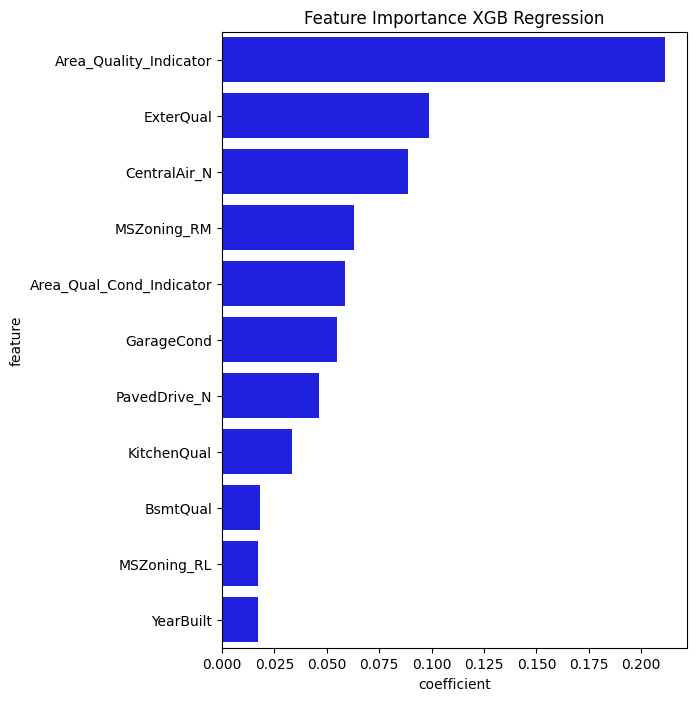

In [69]:
# check feature importance

features_importance = pd.DataFrame({
    'feature': xgb.feature_names_in_,    # get feature
    'coefficient': xgb.feature_importances_            # get coefficient
})

features_importance['coefficient'] = abs(features_importance['coefficient'])  
features_importance = features_importance.sort_values(by='coefficient', ascending=False).reset_index(drop=True)


top_10 = features_importance.loc[:10,:]   # get top ten
plt.figure(figsize=(6,8))
sns.barplot(x= top_10['coefficient'], y= top_10['feature'], color='blue')
plt.title('Feature Importance XGB Regression')

# get useless features
zero = features_importance[features_importance['coefficient'] < 0.001 ].sort_values(by='feature', ascending=True)

# put into dictionary
for feature in zero['feature']:
    useless_feature[feature] = useless_feature.get(feature,0) + 1

# threshold for useful features
threshold = 0.02

# capture useful features
high_coef = features_importance[features_importance['coefficient'] >= threshold].sort_values(by='coefficient', ascending=False) 
high_coef = high_coef.reset_index(drop=True)

for i, feature in enumerate(high_coef['feature']):
    #access based on weight
    useful_feature[feature] = useful_feature.get(feature, 0) + high_coef['coefficient'][i] 

## **LGBM**
#### hyperparameter tuning with GPU works well

In [70]:
lgbm = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    max_depth=-1,
    lambda_l1=0.0001,
    lambda_l2=0,
    learning_rate=0.1,
    n_estimators=100,
    max_bin=200,
    min_child_samples=20,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.8,
    feature_fraction_seed=7,
    verbose=-1,
    device='gpu'  # Use GPU
)

In [71]:
#param_lst = {
#    'max_depth' : [2, 5, 8, 10,15,20],
#    'learning_rate' : [0.01, 0.1, 0.2], #removed 0.001
#    'n_estimators' : [100, 300, 500, 1000, 1500, 2000, 3000],
#    'lambda_l1' : [0.001, 0.01], #removed 0.0001
#    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
#    'feature_fraction' : [0.4, 0.6, 0.8],
#    'min_child_samples' : [2, 5, 10, 20, 25]
#}

#lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
#                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                              cv = 5)
       
#lightgbm_search = lightgbm.fit(X_train, y_train)

#LightBGM with tuned hyperparameters
#best_param = lightgbm_search.best_params_

#best_param = {'n_estimators': 1500,
# 'min_child_samples': 5,
# 'max_depth': 10,
# 'learning_rate': 0.01,
# 'lambda_l2': 0.01,
# 'lambda_l1': 0.01,
# 'feature_fraction': 0.6}

best_param = {'n_estimators': 2000,
 'min_child_samples': 5,
 'max_depth': 5,
 'learning_rate': 0.01,
 'lambda_l2': 0.0001,
 'lambda_l1': 0.001,
 'feature_fraction': 0.4}

lgbm = LGBMRegressor(**best_param)

In [72]:
best_param

{'n_estimators': 2000,
 'min_child_samples': 5,
 'max_depth': 5,
 'learning_rate': 0.01,
 'lambda_l2': 0.0001,
 'lambda_l1': 0.001,
 'feature_fraction': 0.4}

In [73]:
lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_valid) 
preds_test_xgb = lgbm.predict(X_test)
mae_lgbm = mean_absolute_error(y_valid, preds)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

In [74]:
mae_lgbm

0.0755769965247052

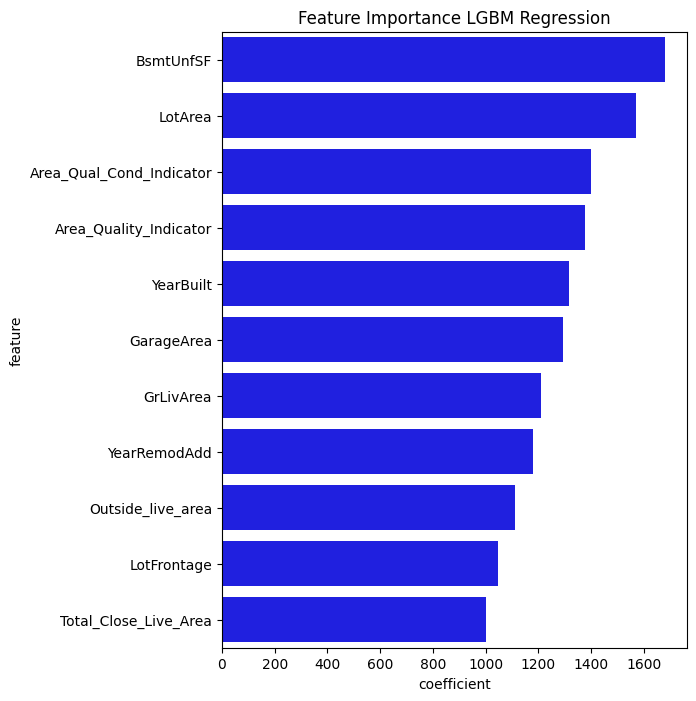

In [75]:
# check feature importance

features_importance = pd.DataFrame({
    'feature': lgbm.feature_names_in_,    # get feature
    'coefficient': lgbm.feature_importances_            # get coefficient
})

features_importance['coefficient'] = abs(features_importance['coefficient'])  
features_importance = features_importance.sort_values(by='coefficient', ascending=False).reset_index(drop=True)


top_10 = features_importance.loc[:10,:]   # get top ten
plt.figure(figsize=(6,8))
sns.barplot(x= top_10['coefficient'], y= top_10['feature'], color='blue')
plt.title('Feature Importance LGBM Regression')

# get useless features
zero = features_importance[features_importance['coefficient'] < 0.001 ].sort_values(by='feature', ascending=True)

# put into dictionary
for feature in zero['feature']:
    useless_feature[feature] = useless_feature.get(feature,0) + 1

# threshold for useful features
threshold = 0.02

# capture useful features
high_coef = features_importance[features_importance['coefficient'] >= threshold].sort_values(by='coefficient', ascending=False) 
high_coef = high_coef.reset_index(drop=True)

for i, feature in enumerate(high_coef['feature']):
    #access based on weight
    useful_feature[feature] = useful_feature.get(feature, 0) + high_coef['coefficient'][i] 

## **CatBoost**
#### catboost takes a while to train, other regression models like Ridge work just as well and take much less time, with or without the GPU. 

In [76]:
cb = CatBoostRegressor(
    loss_function='RMSE',
    logging_level='Silent',
    task_type='GPU'  # Use GPU
)

In [77]:
#param_lst = {
#    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
#    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
#    'l2_leaf_reg' : [0.001, 0.01, 0.1],
#    'random_strength' : [0.25, 0.5 ,1],
#    'max_depth' : [3, 6, 9],
#    'min_child_samples' : [2, 5, 10, 15, 20],
#    'rsm' : [0.5, 0.7, 0.9],  
#}

#catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
#                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                              cv = 5)

#catboost_search = catboost.fit(X_train, y_train)

# CatBoost with tuned hyperparams
#best_param = catboost_search.best_params_

best_param = {'random_strength': 0.25,
 'n_estimators': 1600,
 'min_child_samples': 10,
 'max_depth': 6,
 'learning_rate': 0.01,
 'l2_leaf_reg': 0.01}

cb = CatBoostRegressor(logging_level='Silent', **best_param)

In [78]:
cb.fit(X_train, y_train)   
preds = cb.predict(X_valid) 
preds_test_xgb = cb.predict(X_test)
mae_cb = mean_absolute_error(y_valid, preds)

In [79]:
mae_cb

0.07604153267545284

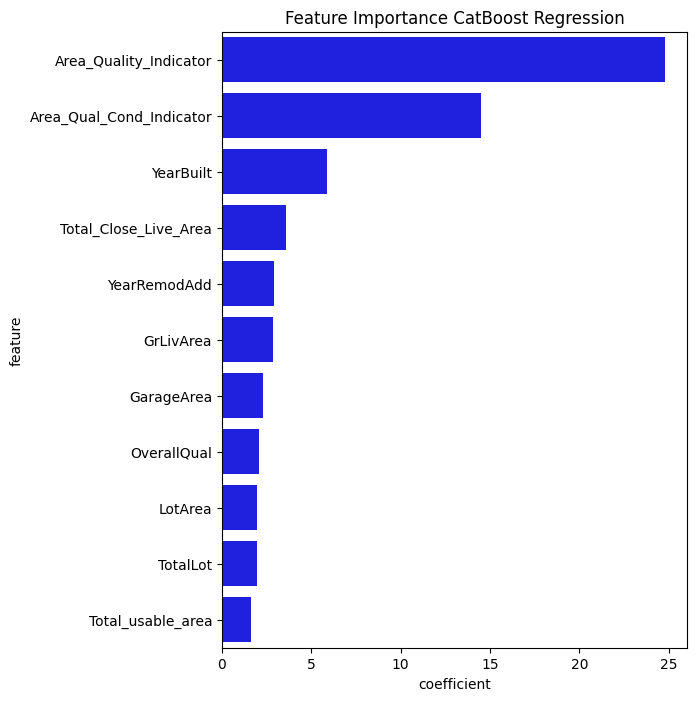

In [80]:
# check feature importance

features_importance = pd.DataFrame({
    'feature': X_train.columns,    # get feature
    'coefficient': cb.feature_importances_            # get coefficient
})

features_importance['coefficient'] = abs(features_importance['coefficient'])  
features_importance = features_importance.sort_values(by='coefficient', ascending=False).reset_index(drop=True)


top_10 = features_importance.loc[:10,:]   # get top ten
plt.figure(figsize=(6,8))
sns.barplot(x= top_10['coefficient'], y= top_10['feature'], color='blue')
plt.title('Feature Importance CatBoost Regression')

# get useless features
zero = features_importance[features_importance['coefficient'] < 0.001 ].sort_values(by='feature', ascending=True)

# put into dictionary
for feature in zero['feature']:
    useless_feature[feature] = useless_feature.get(feature,0) + 1

# threshold for useful features
threshold = 0.02

# capture useful features
high_coef = features_importance[features_importance['coefficient'] >= threshold].sort_values(by='coefficient', ascending=False) 
high_coef = high_coef.reset_index(drop=True)

for i, feature in enumerate(high_coef['feature']):
    #access based on weight
    useful_feature[feature] = useful_feature.get(feature, 0) + high_coef['coefficient'][i] 

## **Review of Models**

In [81]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

huber.fit(X_train, y_train)   
preds = huber.predict(X_valid) 
preds_test_cb = huber.predict(X_test)
mae_huber = mean_absolute_error(y_valid, preds)
rmse_huber = np.sqrt(mean_squared_error(y_valid, preds))
score_huber = huber.score(X_valid, y_valid)
cv_huber = mean_cross_val(huber, x, y)

ridge.fit(X_train, y_train)   
preds = ridge.predict(X_valid) 
preds_test_cb = ridge.predict(X_test)
mae_ridge = mean_absolute_error(y_valid, preds)
rmse_ridge = np.sqrt(mean_squared_error(y_valid, preds))
score_ridge = ridge.score(X_valid, y_valid)
cv_ridge = mean_cross_val(ridge, x, y)

cb.fit(X_train, y_train)   
preds = cb.predict(X_valid) 
preds_test_cb = cb.predict(X_test)
mae_cb = mean_absolute_error(y_valid, preds)
rmse_cb = np.sqrt(mean_squared_error(y_valid, preds))
score_cb = cb.score(X_valid, y_valid)
cv_cb = mean_cross_val(cb, x, y)

xgb.fit(X_train, y_train)   
preds = xgb.predict(X_valid) 
preds_test_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_valid, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, preds))
score_xgb = xgb.score(X_valid, y_valid)
cv_xgb = mean_cross_val(xgb, x, y)

lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_valid) 
preds_test_lgbm = lgbm.predict(X_test)
mae_lgbm = mean_absolute_error(y_valid, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_valid, preds))
score_lgbm = lgbm.score(X_valid, y_valid)
cv_lgbm = mean_cross_val(lgbm, x, y)


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

In [82]:
model_performances = pd.DataFrame({
    "Model" : ["Huber", "Ridge", "XGBoost", "LGBM", "CatBoost", 'Keras NN'],
    "CV(5)" : [str(cv_huber)[0:5],str(cv_ridge)[0:5],str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5], str('NA')],
    "MAE" : [str(mae_huber)[0:5],str(mae_ridge)[0:5],str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5],str(mae_keras_nn)],
    "RMSE" : [str(rmse_huber)[0:5],str(rmse_ridge)[0:5],str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5], str(rmse_keras_nn)],
    "Score" : [str(score_huber)[0:5],str(score_ridge)[0:5],str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5], str('NA')]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="MAE", ascending=True))

Sorted by Score:
      Model  CV(5)     MAE   RMSE  Score
3      LGBM  0.919   0.075  0.108  0.928
4  CatBoost  0.916   0.076  0.111  0.924
1     Ridge  0.920   0.079  0.110  0.926
2   XGBoost  0.913   0.079  0.110  0.926
0     Huber  0.875   0.107  0.143  0.875
5  Keras NN     NA  12.119  4.944     NA


In [83]:
# def blend_models_predict(X, b, c, d,e):
#    pred_ridge = ridge.predict(X).flatten()
#    return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X))+ (e * pred_ridge))

In [84]:
#subm = np.exp(blend_models_predict(X_test, 0.25, 0.25, 0.25, 0.25))
#submission = pd.DataFrame({'Id': X_test.index,
#                           'SalePrice': subm})

#submission.to_csv("../../kaggle/working/submission.csv", index=False)

## **Stacked Regression Model**

In [85]:
cv_fold = KFold(n_splits= 10, shuffle=True, random_state=12)

# CREATE STACKING REGRESSOR
model = StackingRegressor(
    estimators=[
        ('ridge', ridge),        
        ('xgboost', xgb),
        ('lightgbm', lgbm),
        ('catboost', cb)
    ],  
        final_estimator = RidgeCV(),
        cv=cv_fold
)

model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

StackingRegressor(cv=KFold(n_splits=10, random_state=12, shuffle=True),
                  estimators=[('ridge', Ridge(alpha=10.0, max_iter=50)),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lightgbm',
                               LGBMRegressor(feature_fraction=0.4,
                                             lambda_l1=0.001, lambda_l2=0.0001,
                                             learning_rate=0.01, max_depth=5,
                                             min_child_samples=5,
                                             n_estimators=2000)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7dba1c623580>)],
                  final_estimator=RidgeCV())

## **Useful and Useless Features**

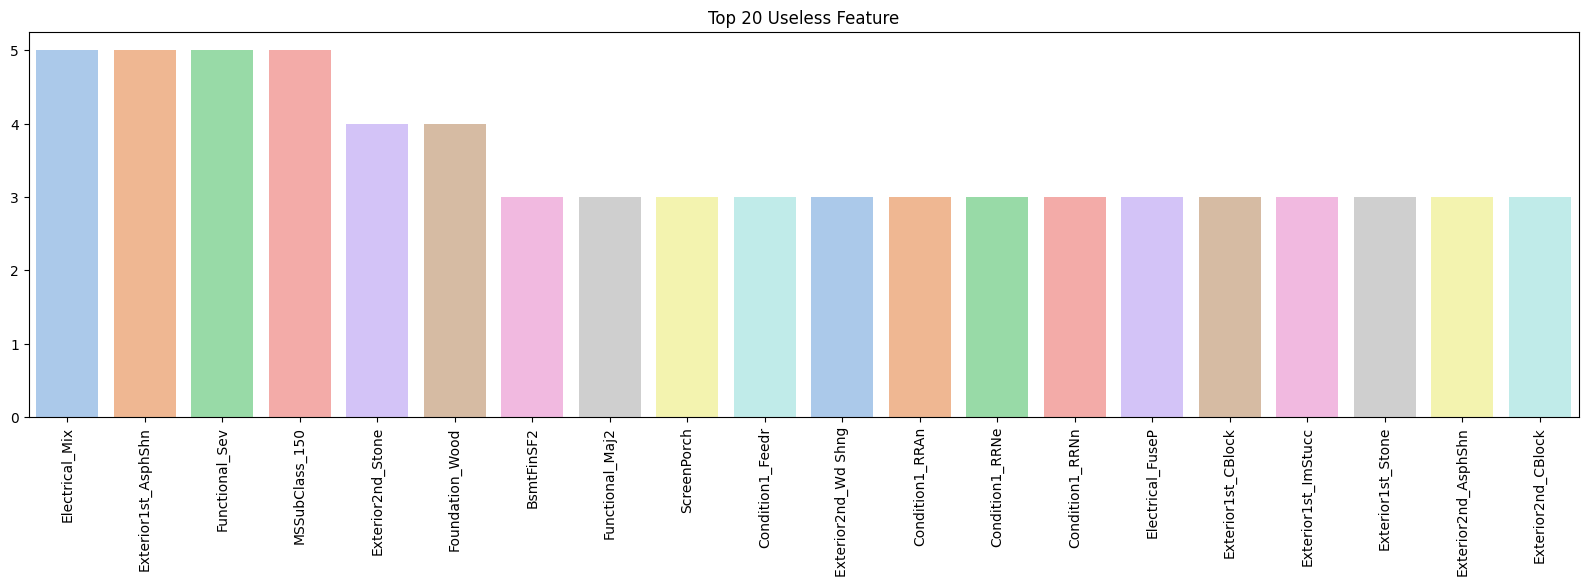

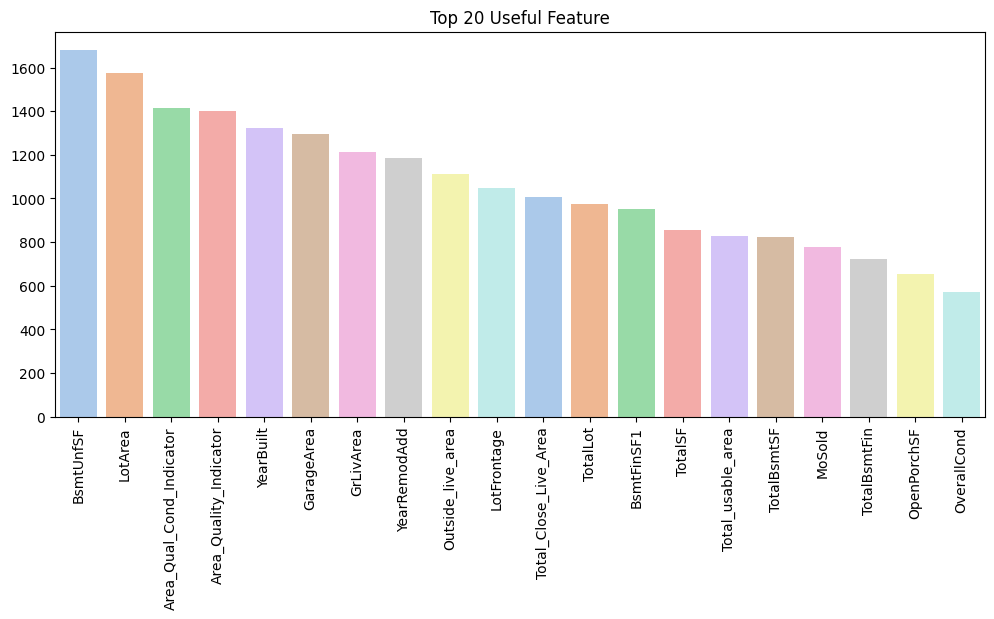

In [86]:
top_20_useless = dict(sorted(useless_feature.items(), key=lambda item: item[1], reverse=True)[:20])   
top_20_useful  = dict(sorted(useful_feature.items(), key=lambda item: item[1], reverse=True)[:20])   

plt.figure(figsize=(20,5))     

useless_values = list(top_20_useless.values())  
useless_keys   = list(top_20_useless.keys())

sns.barplot(x=useless_keys, y= useless_values, palette='pastel')    
plt.title('Top 20 Useless Feature')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12,5))

useful_values = list(top_20_useful.values())   
useful_keys   = list(top_20_useful.keys())

sns.barplot(x= useful_keys, y= useful_values, palette='pastel')  
plt.title('Top 20 Useful Feature')
plt.xticks(rotation=90)
plt.show()

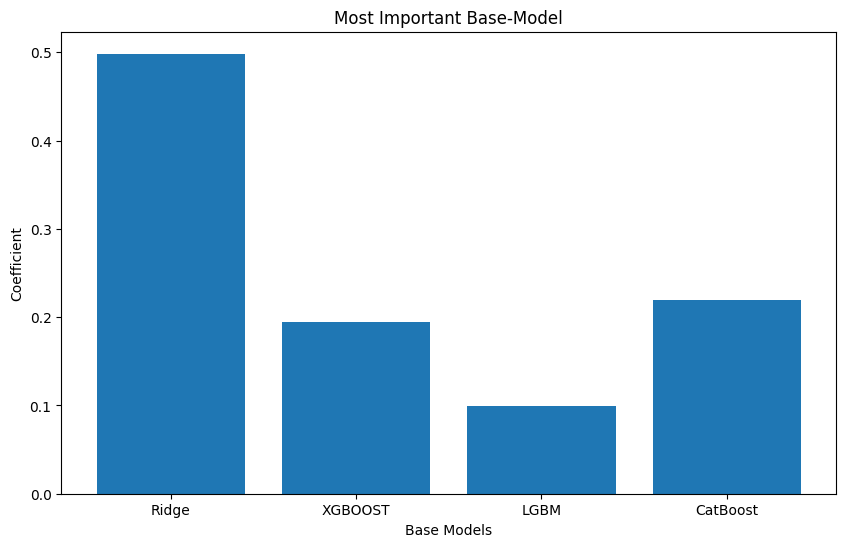

In [87]:
# Trained Models
base_models = [ 'Ridge', 'XGBOOST', 'LGBM', 'CatBoost']

meta_model = model.final_estimator_ 
coefficients = meta_model.coef_   # GET COEFFICIENT FOR EACH MODEL

# VISUALIZE MODEL IMPORTANCE
plt.figure(figsize=(10,6))
plt.bar(base_models, coefficients)
plt.xlabel('Base Models')
plt.ylabel('Coefficient')
plt.title('Most Important Base-Model')
plt.show()

## **Prediction and Submission**

In [88]:
subm = np.exp(model.predict(X_test))
submission = pd.DataFrame({'Id': X_test.index,
                           'SalePrice': subm})

submission.to_csv("../../kaggle/working/submission.csv", index=False)
submission

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001


Id  SalePrice
0     1461  125574.06
1     1462  167909.76
2     1463  182866.42
3     1464  199663.30
4     1465  185533.76
...    ...        ...
1454  2915   85537.92
1455  2916   81587.82
1456  2917  169910.61
1457  2918  118046.39
1458  2919  216988.10

[1459 rows x 2 columns]